# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [74]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [75]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import os
from torch.utils.data import DataLoader

In [76]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    image_path = "./" + data_dir
        
    train_dataset = datasets.ImageFolder(image_path, transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [77]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

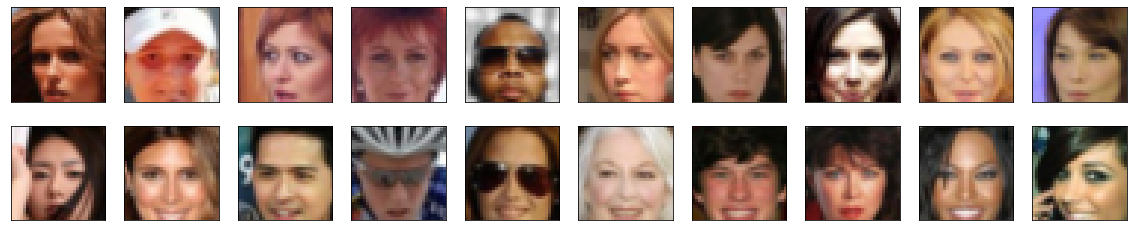

In [78]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [79]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9216)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [81]:
import torch.nn as nn
import torch.nn.functional as F

In [82]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization"""
    layers = []
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                            kernel_size=kernel_size, stride=stride, padding=padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [102]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, batch_norm=False) # x, y = 32, depth 32
        self.conv2 = conv(conv_dim, conv_dim * 2) #(16, 16, 64)
        self.conv3 = conv(conv_dim * 2, conv_dim*4) #(8, 8, 128)
       # self.conv4 = conv(conv_dim*4, conv_dim*8) #(4, 4, 256)
       # self.conv5 = conv(conv_dim*8, conv_dim*16) #(2, 2, 512)
        
        # Classification layer
        self.classifier = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        #out = F.relu(self.conv4(out))
        #out = F.relu(self.conv5(out))
        
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.classifier(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [103]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization."""
    
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [105]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        # Fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        # Convolutional layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.t_conv2 = deconv(conv_dim*2, conv_dim)        
        self.t_conv3 = deconv(conv_dim, 3, batch_norm=False)

        self.tanh = nn.Tanh()
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) #(batch_size, depth, 2, 2)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        #out = F.relu(self.t_conv3(out))
        #out = F.relu(self.t_conv4(out))
        out = self.t_conv3(out)
        out = self.tanh(out)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [106]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    std_dev = 0.02
    mean = 0.0
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, mean, std_dev)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [107]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [108]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [109]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [110]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) * 0.9
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [111]:
import torch.optim as optim

lr=0.0002
beta1=0.5
beta2=0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [112]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [118]:
# set number of epochs 
n_epochs = 1000


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/ 1000] | d_loss: 1.1124 | g_loss: 1.6662
Epoch [    1/ 1000] | d_loss: 0.7699 | g_loss: 1.3472
Epoch [    1/ 1000] | d_loss: 1.1291 | g_loss: 1.3291
Epoch [    1/ 1000] | d_loss: 0.8733 | g_loss: 1.8651
Epoch [    1/ 1000] | d_loss: 0.7491 | g_loss: 2.0686
Epoch [    1/ 1000] | d_loss: 1.0315 | g_loss: 1.3803
Epoch [    1/ 1000] | d_loss: 0.7946 | g_loss: 1.9796
Epoch [    1/ 1000] | d_loss: 0.6901 | g_loss: 2.2218
Epoch [    1/ 1000] | d_loss: 1.1986 | g_loss: 1.8985
Epoch [    1/ 1000] | d_loss: 0.7871 | g_loss: 1.9510
Epoch [    1/ 1000] | d_loss: 0.7446 | g_loss: 1.8030
Epoch [    1/ 1000] | d_loss: 0.7792 | g_loss: 1.8439
Epoch [    1/ 1000] | d_loss: 0.5817 | g_loss: 2.0846
Epoch [    1/ 1000] | d_loss: 0.8861 | g_loss: 2.2209
Epoch [    1/ 1000] | d_loss: 0.8173 | g_loss: 2.5671
Epoch [    1/ 1000] | d_loss: 0.9445 | g_loss: 2.1111
Epoch [    2/ 1000] | d_loss: 0.9587 | g_loss: 1.4247
Epoch [    2/ 1000] | d_loss: 0.7517 | g_loss: 1.4428
Epoch [    2/ 1000] | d_loss

Epoch [   10/ 1000] | d_loss: 0.7959 | g_loss: 1.4176
Epoch [   10/ 1000] | d_loss: 0.6892 | g_loss: 1.3579
Epoch [   10/ 1000] | d_loss: 0.5961 | g_loss: 1.8260
Epoch [   10/ 1000] | d_loss: 0.6097 | g_loss: 2.5410
Epoch [   10/ 1000] | d_loss: 0.7839 | g_loss: 1.3577
Epoch [   10/ 1000] | d_loss: 0.6623 | g_loss: 2.4217
Epoch [   10/ 1000] | d_loss: 0.9546 | g_loss: 2.7098
Epoch [   10/ 1000] | d_loss: 0.6862 | g_loss: 2.2569
Epoch [   11/ 1000] | d_loss: 0.5229 | g_loss: 2.7895
Epoch [   11/ 1000] | d_loss: 0.8836 | g_loss: 1.9100
Epoch [   11/ 1000] | d_loss: 0.5067 | g_loss: 2.5275
Epoch [   11/ 1000] | d_loss: 0.7292 | g_loss: 1.8804
Epoch [   11/ 1000] | d_loss: 0.5499 | g_loss: 1.9750
Epoch [   11/ 1000] | d_loss: 0.6040 | g_loss: 2.0016
Epoch [   11/ 1000] | d_loss: 0.7875 | g_loss: 1.8464
Epoch [   11/ 1000] | d_loss: 0.6309 | g_loss: 2.3037
Epoch [   11/ 1000] | d_loss: 0.4992 | g_loss: 1.0595
Epoch [   11/ 1000] | d_loss: 0.6957 | g_loss: 2.2423
Epoch [   11/ 1000] | d_loss

Epoch [   20/ 1000] | d_loss: 0.8156 | g_loss: 1.7529
Epoch [   20/ 1000] | d_loss: 0.5930 | g_loss: 2.1782
Epoch [   20/ 1000] | d_loss: 0.5950 | g_loss: 2.6055
Epoch [   20/ 1000] | d_loss: 0.6811 | g_loss: 2.0589
Epoch [   20/ 1000] | d_loss: 0.4477 | g_loss: 2.0522
Epoch [   20/ 1000] | d_loss: 0.7358 | g_loss: 2.3707
Epoch [   20/ 1000] | d_loss: 0.4992 | g_loss: 3.2579
Epoch [   20/ 1000] | d_loss: 0.5855 | g_loss: 1.9214
Epoch [   20/ 1000] | d_loss: 0.5653 | g_loss: 2.4506
Epoch [   20/ 1000] | d_loss: 0.5794 | g_loss: 3.3878
Epoch [   20/ 1000] | d_loss: 0.8575 | g_loss: 1.2183
Epoch [   20/ 1000] | d_loss: 0.7194 | g_loss: 1.5369
Epoch [   20/ 1000] | d_loss: 0.4482 | g_loss: 3.7415
Epoch [   20/ 1000] | d_loss: 0.8120 | g_loss: 1.9020
Epoch [   20/ 1000] | d_loss: 0.7319 | g_loss: 2.3114
Epoch [   20/ 1000] | d_loss: 0.6918 | g_loss: 1.9147
Epoch [   21/ 1000] | d_loss: 0.6458 | g_loss: 2.7810
Epoch [   21/ 1000] | d_loss: 0.6730 | g_loss: 1.9824
Epoch [   21/ 1000] | d_loss

Epoch [   29/ 1000] | d_loss: 0.5837 | g_loss: 1.2408
Epoch [   29/ 1000] | d_loss: 0.4772 | g_loss: 2.8969
Epoch [   29/ 1000] | d_loss: 0.4796 | g_loss: 2.2220
Epoch [   29/ 1000] | d_loss: 0.5671 | g_loss: 2.5174
Epoch [   29/ 1000] | d_loss: 0.8389 | g_loss: 2.0313
Epoch [   29/ 1000] | d_loss: 0.4741 | g_loss: 2.2352
Epoch [   29/ 1000] | d_loss: 0.5867 | g_loss: 3.1527
Epoch [   29/ 1000] | d_loss: 0.4813 | g_loss: 3.8749
Epoch [   30/ 1000] | d_loss: 0.5145 | g_loss: 2.2159
Epoch [   30/ 1000] | d_loss: 0.6303 | g_loss: 2.5314
Epoch [   30/ 1000] | d_loss: 0.5610 | g_loss: 2.6355
Epoch [   30/ 1000] | d_loss: 0.6211 | g_loss: 1.8139
Epoch [   30/ 1000] | d_loss: 0.4270 | g_loss: 3.5768
Epoch [   30/ 1000] | d_loss: 0.5931 | g_loss: 3.1584
Epoch [   30/ 1000] | d_loss: 0.4955 | g_loss: 3.7183
Epoch [   30/ 1000] | d_loss: 0.4685 | g_loss: 2.5221
Epoch [   30/ 1000] | d_loss: 0.7369 | g_loss: 3.3237
Epoch [   30/ 1000] | d_loss: 0.7697 | g_loss: 2.6699
Epoch [   30/ 1000] | d_loss

Epoch [   39/ 1000] | d_loss: 0.5303 | g_loss: 4.2979
Epoch [   39/ 1000] | d_loss: 0.5112 | g_loss: 3.2427
Epoch [   39/ 1000] | d_loss: 0.4275 | g_loss: 2.7019
Epoch [   39/ 1000] | d_loss: 0.6049 | g_loss: 3.3596
Epoch [   39/ 1000] | d_loss: 0.4769 | g_loss: 2.0330
Epoch [   39/ 1000] | d_loss: 0.6237 | g_loss: 2.9834
Epoch [   39/ 1000] | d_loss: 0.4738 | g_loss: 3.6456
Epoch [   39/ 1000] | d_loss: 0.4429 | g_loss: 2.9590
Epoch [   39/ 1000] | d_loss: 0.5052 | g_loss: 3.5675
Epoch [   39/ 1000] | d_loss: 0.4539 | g_loss: 2.8660
Epoch [   39/ 1000] | d_loss: 0.6036 | g_loss: 2.6061
Epoch [   39/ 1000] | d_loss: 0.7203 | g_loss: 3.0865
Epoch [   39/ 1000] | d_loss: 0.8235 | g_loss: 2.9106
Epoch [   39/ 1000] | d_loss: 0.5080 | g_loss: 3.1840
Epoch [   39/ 1000] | d_loss: 0.4542 | g_loss: 3.8055
Epoch [   39/ 1000] | d_loss: 0.5605 | g_loss: 2.4721
Epoch [   40/ 1000] | d_loss: 0.8802 | g_loss: 3.4144
Epoch [   40/ 1000] | d_loss: 0.4882 | g_loss: 3.1585
Epoch [   40/ 1000] | d_loss

Epoch [   48/ 1000] | d_loss: 0.4654 | g_loss: 3.2965
Epoch [   48/ 1000] | d_loss: 0.5335 | g_loss: 3.1595
Epoch [   48/ 1000] | d_loss: 0.6032 | g_loss: 3.3250
Epoch [   48/ 1000] | d_loss: 0.5582 | g_loss: 2.1835
Epoch [   48/ 1000] | d_loss: 0.5197 | g_loss: 3.1718
Epoch [   48/ 1000] | d_loss: 0.5008 | g_loss: 2.8977
Epoch [   48/ 1000] | d_loss: 0.4628 | g_loss: 3.0824
Epoch [   48/ 1000] | d_loss: 0.4848 | g_loss: 1.9108
Epoch [   49/ 1000] | d_loss: 0.4478 | g_loss: 3.7738
Epoch [   49/ 1000] | d_loss: 0.5561 | g_loss: 3.5308
Epoch [   49/ 1000] | d_loss: 0.6975 | g_loss: 2.7433
Epoch [   49/ 1000] | d_loss: 0.4657 | g_loss: 2.5868
Epoch [   49/ 1000] | d_loss: 0.5904 | g_loss: 2.9387
Epoch [   49/ 1000] | d_loss: 0.5252 | g_loss: 2.7697
Epoch [   49/ 1000] | d_loss: 0.4283 | g_loss: 3.1675
Epoch [   49/ 1000] | d_loss: 0.5968 | g_loss: 2.1931
Epoch [   49/ 1000] | d_loss: 0.4974 | g_loss: 2.5880
Epoch [   49/ 1000] | d_loss: 0.4922 | g_loss: 2.7898
Epoch [   49/ 1000] | d_loss

Epoch [   58/ 1000] | d_loss: 0.4766 | g_loss: 3.7704
Epoch [   58/ 1000] | d_loss: 0.3879 | g_loss: 3.5904
Epoch [   58/ 1000] | d_loss: 0.6527 | g_loss: 3.6921
Epoch [   58/ 1000] | d_loss: 0.5157 | g_loss: 2.9872
Epoch [   58/ 1000] | d_loss: 0.4326 | g_loss: 3.2923
Epoch [   58/ 1000] | d_loss: 0.4528 | g_loss: 3.6434
Epoch [   58/ 1000] | d_loss: 0.5763 | g_loss: 3.0550
Epoch [   58/ 1000] | d_loss: 0.4877 | g_loss: 2.7195
Epoch [   58/ 1000] | d_loss: 0.4077 | g_loss: 3.0163
Epoch [   58/ 1000] | d_loss: 0.5323 | g_loss: 2.7693
Epoch [   58/ 1000] | d_loss: 0.5981 | g_loss: 3.7077
Epoch [   58/ 1000] | d_loss: 0.3688 | g_loss: 4.3370
Epoch [   58/ 1000] | d_loss: 0.5625 | g_loss: 3.3237
Epoch [   58/ 1000] | d_loss: 0.5185 | g_loss: 3.0684
Epoch [   58/ 1000] | d_loss: 0.4445 | g_loss: 4.0000
Epoch [   58/ 1000] | d_loss: 0.4902 | g_loss: 4.3878
Epoch [   59/ 1000] | d_loss: 0.4069 | g_loss: 2.5317
Epoch [   59/ 1000] | d_loss: 0.4682 | g_loss: 3.3686
Epoch [   59/ 1000] | d_loss

Epoch [   67/ 1000] | d_loss: 0.6945 | g_loss: 3.9656
Epoch [   67/ 1000] | d_loss: 0.4548 | g_loss: 4.9678
Epoch [   67/ 1000] | d_loss: 0.4887 | g_loss: 3.3129
Epoch [   67/ 1000] | d_loss: 0.4326 | g_loss: 3.2874
Epoch [   67/ 1000] | d_loss: 0.5212 | g_loss: 3.2275
Epoch [   67/ 1000] | d_loss: 0.6472 | g_loss: 2.6074
Epoch [   67/ 1000] | d_loss: 0.4085 | g_loss: 3.5356
Epoch [   67/ 1000] | d_loss: 0.3760 | g_loss: 4.2874
Epoch [   68/ 1000] | d_loss: 0.6916 | g_loss: 3.4032
Epoch [   68/ 1000] | d_loss: 0.4499 | g_loss: 3.6302
Epoch [   68/ 1000] | d_loss: 0.4983 | g_loss: 3.0538
Epoch [   68/ 1000] | d_loss: 0.4126 | g_loss: 3.9234
Epoch [   68/ 1000] | d_loss: 0.6799 | g_loss: 2.2119
Epoch [   68/ 1000] | d_loss: 0.4314 | g_loss: 2.9330
Epoch [   68/ 1000] | d_loss: 0.5226 | g_loss: 3.3842
Epoch [   68/ 1000] | d_loss: 0.5866 | g_loss: 2.5896
Epoch [   68/ 1000] | d_loss: 0.4198 | g_loss: 3.8130
Epoch [   68/ 1000] | d_loss: 0.4993 | g_loss: 2.7837
Epoch [   68/ 1000] | d_loss

Epoch [   77/ 1000] | d_loss: 0.5223 | g_loss: 2.6906
Epoch [   77/ 1000] | d_loss: 0.4051 | g_loss: 3.8102
Epoch [   77/ 1000] | d_loss: 0.4552 | g_loss: 4.0575
Epoch [   77/ 1000] | d_loss: 0.4289 | g_loss: 3.7846
Epoch [   77/ 1000] | d_loss: 0.3912 | g_loss: 3.6747
Epoch [   77/ 1000] | d_loss: 0.6524 | g_loss: 4.4326
Epoch [   77/ 1000] | d_loss: 0.3865 | g_loss: 3.8942
Epoch [   77/ 1000] | d_loss: 0.4819 | g_loss: 3.0829
Epoch [   77/ 1000] | d_loss: 0.6479 | g_loss: 2.4654
Epoch [   77/ 1000] | d_loss: 0.5226 | g_loss: 2.9028
Epoch [   77/ 1000] | d_loss: 0.6241 | g_loss: 3.8975
Epoch [   77/ 1000] | d_loss: 0.4254 | g_loss: 3.1234
Epoch [   77/ 1000] | d_loss: 0.3998 | g_loss: 3.9628
Epoch [   77/ 1000] | d_loss: 0.4941 | g_loss: 3.6401
Epoch [   77/ 1000] | d_loss: 0.5484 | g_loss: 3.5507
Epoch [   77/ 1000] | d_loss: 0.4731 | g_loss: 4.3831
Epoch [   78/ 1000] | d_loss: 0.4235 | g_loss: 3.3785
Epoch [   78/ 1000] | d_loss: 0.5632 | g_loss: 2.8870
Epoch [   78/ 1000] | d_loss

Epoch [   86/ 1000] | d_loss: 0.4845 | g_loss: 4.3295
Epoch [   86/ 1000] | d_loss: 0.3932 | g_loss: 3.6024
Epoch [   86/ 1000] | d_loss: 0.5285 | g_loss: 3.8042
Epoch [   86/ 1000] | d_loss: 0.4294 | g_loss: 3.6288
Epoch [   86/ 1000] | d_loss: 0.5258 | g_loss: 3.1495
Epoch [   86/ 1000] | d_loss: 0.4048 | g_loss: 4.8390
Epoch [   86/ 1000] | d_loss: 0.6283 | g_loss: 1.7127
Epoch [   86/ 1000] | d_loss: 0.5938 | g_loss: 3.5152
Epoch [   87/ 1000] | d_loss: 0.4257 | g_loss: 3.6643
Epoch [   87/ 1000] | d_loss: 0.3991 | g_loss: 3.2669
Epoch [   87/ 1000] | d_loss: 0.4620 | g_loss: 3.1408
Epoch [   87/ 1000] | d_loss: 0.4246 | g_loss: 3.0150
Epoch [   87/ 1000] | d_loss: 0.4467 | g_loss: 4.0338
Epoch [   87/ 1000] | d_loss: 0.4483 | g_loss: 4.2532
Epoch [   87/ 1000] | d_loss: 0.4527 | g_loss: 3.1974
Epoch [   87/ 1000] | d_loss: 0.4582 | g_loss: 4.2972
Epoch [   87/ 1000] | d_loss: 0.4116 | g_loss: 3.7557
Epoch [   87/ 1000] | d_loss: 0.4811 | g_loss: 2.3011
Epoch [   87/ 1000] | d_loss

Epoch [   96/ 1000] | d_loss: 0.4316 | g_loss: 3.8149
Epoch [   96/ 1000] | d_loss: 0.4307 | g_loss: 3.7910
Epoch [   96/ 1000] | d_loss: 0.4213 | g_loss: 4.1780
Epoch [   96/ 1000] | d_loss: 0.7222 | g_loss: 3.3554
Epoch [   96/ 1000] | d_loss: 0.4136 | g_loss: 4.1618
Epoch [   96/ 1000] | d_loss: 0.4243 | g_loss: 4.0245
Epoch [   96/ 1000] | d_loss: 0.4138 | g_loss: 2.6998
Epoch [   96/ 1000] | d_loss: 0.5826 | g_loss: 3.0734
Epoch [   96/ 1000] | d_loss: 0.6385 | g_loss: 2.7634
Epoch [   96/ 1000] | d_loss: 0.9183 | g_loss: 3.0665
Epoch [   96/ 1000] | d_loss: 0.5043 | g_loss: 3.7843
Epoch [   96/ 1000] | d_loss: 0.5858 | g_loss: 3.4296
Epoch [   96/ 1000] | d_loss: 0.3991 | g_loss: 3.9639
Epoch [   96/ 1000] | d_loss: 0.4602 | g_loss: 2.8727
Epoch [   96/ 1000] | d_loss: 0.7201 | g_loss: 3.5038
Epoch [   96/ 1000] | d_loss: 0.4118 | g_loss: 4.6571
Epoch [   97/ 1000] | d_loss: 0.4572 | g_loss: 4.4293
Epoch [   97/ 1000] | d_loss: 0.4412 | g_loss: 2.2467
Epoch [   97/ 1000] | d_loss

Epoch [  105/ 1000] | d_loss: 0.5809 | g_loss: 2.6123
Epoch [  105/ 1000] | d_loss: 0.4470 | g_loss: 3.2513
Epoch [  105/ 1000] | d_loss: 0.4106 | g_loss: 4.6704
Epoch [  105/ 1000] | d_loss: 1.2498 | g_loss: 0.8838
Epoch [  105/ 1000] | d_loss: 0.5649 | g_loss: 3.6303
Epoch [  105/ 1000] | d_loss: 0.6136 | g_loss: 3.3318
Epoch [  105/ 1000] | d_loss: 0.6454 | g_loss: 2.9358
Epoch [  105/ 1000] | d_loss: 0.3760 | g_loss: 3.3826
Epoch [  106/ 1000] | d_loss: 0.4704 | g_loss: 4.0909
Epoch [  106/ 1000] | d_loss: 0.4387 | g_loss: 3.3332
Epoch [  106/ 1000] | d_loss: 0.4515 | g_loss: 3.2082
Epoch [  106/ 1000] | d_loss: 0.4288 | g_loss: 3.9050
Epoch [  106/ 1000] | d_loss: 0.4202 | g_loss: 3.6528
Epoch [  106/ 1000] | d_loss: 0.4201 | g_loss: 3.6940
Epoch [  106/ 1000] | d_loss: 0.4412 | g_loss: 4.1426
Epoch [  106/ 1000] | d_loss: 0.4723 | g_loss: 3.8532
Epoch [  106/ 1000] | d_loss: 0.4170 | g_loss: 3.0610
Epoch [  106/ 1000] | d_loss: 0.4494 | g_loss: 4.0803
Epoch [  106/ 1000] | d_loss

Epoch [  115/ 1000] | d_loss: 0.8181 | g_loss: 3.5286
Epoch [  115/ 1000] | d_loss: 0.5618 | g_loss: 3.4072
Epoch [  115/ 1000] | d_loss: 0.4511 | g_loss: 4.1342
Epoch [  115/ 1000] | d_loss: 0.4773 | g_loss: 2.8865
Epoch [  115/ 1000] | d_loss: 0.6420 | g_loss: 3.9810
Epoch [  115/ 1000] | d_loss: 0.6731 | g_loss: 4.1460
Epoch [  115/ 1000] | d_loss: 0.5506 | g_loss: 3.2663
Epoch [  115/ 1000] | d_loss: 0.4157 | g_loss: 4.2730
Epoch [  115/ 1000] | d_loss: 0.6730 | g_loss: 2.3985
Epoch [  115/ 1000] | d_loss: 0.4457 | g_loss: 3.5812
Epoch [  115/ 1000] | d_loss: 0.4632 | g_loss: 3.9031
Epoch [  115/ 1000] | d_loss: 0.3953 | g_loss: 3.9526
Epoch [  115/ 1000] | d_loss: 0.5112 | g_loss: 3.3135
Epoch [  115/ 1000] | d_loss: 0.4522 | g_loss: 4.3279
Epoch [  115/ 1000] | d_loss: 0.5193 | g_loss: 2.7974
Epoch [  115/ 1000] | d_loss: 0.3844 | g_loss: 3.8926
Epoch [  116/ 1000] | d_loss: 0.4767 | g_loss: 3.8312
Epoch [  116/ 1000] | d_loss: 0.4222 | g_loss: 4.1415
Epoch [  116/ 1000] | d_loss

Epoch [  124/ 1000] | d_loss: 0.4060 | g_loss: 4.2966
Epoch [  124/ 1000] | d_loss: 0.4109 | g_loss: 3.5867
Epoch [  124/ 1000] | d_loss: 0.4798 | g_loss: 3.3526
Epoch [  124/ 1000] | d_loss: 0.6512 | g_loss: 4.3854
Epoch [  124/ 1000] | d_loss: 0.4975 | g_loss: 3.4336
Epoch [  124/ 1000] | d_loss: 0.4302 | g_loss: 3.4036
Epoch [  124/ 1000] | d_loss: 0.4514 | g_loss: 3.4276
Epoch [  124/ 1000] | d_loss: 0.4354 | g_loss: 3.0665
Epoch [  125/ 1000] | d_loss: 0.8355 | g_loss: 1.7936
Epoch [  125/ 1000] | d_loss: 0.4072 | g_loss: 3.4173
Epoch [  125/ 1000] | d_loss: 0.3611 | g_loss: 5.0517
Epoch [  125/ 1000] | d_loss: 0.5162 | g_loss: 3.2221
Epoch [  125/ 1000] | d_loss: 0.4526 | g_loss: 3.2690
Epoch [  125/ 1000] | d_loss: 0.5378 | g_loss: 3.2785
Epoch [  125/ 1000] | d_loss: 0.5328 | g_loss: 2.8426
Epoch [  125/ 1000] | d_loss: 0.4338 | g_loss: 4.0554
Epoch [  125/ 1000] | d_loss: 0.5598 | g_loss: 2.4688
Epoch [  125/ 1000] | d_loss: 0.3871 | g_loss: 4.1235
Epoch [  125/ 1000] | d_loss

Epoch [  134/ 1000] | d_loss: 0.4785 | g_loss: 3.6611
Epoch [  134/ 1000] | d_loss: 0.3821 | g_loss: 4.7881
Epoch [  134/ 1000] | d_loss: 0.4537 | g_loss: 4.4977
Epoch [  134/ 1000] | d_loss: 0.5103 | g_loss: 2.8588
Epoch [  134/ 1000] | d_loss: 0.9248 | g_loss: 2.8747
Epoch [  134/ 1000] | d_loss: 0.4898 | g_loss: 3.5965
Epoch [  134/ 1000] | d_loss: 0.4919 | g_loss: 1.7244
Epoch [  134/ 1000] | d_loss: 0.4250 | g_loss: 3.8188
Epoch [  134/ 1000] | d_loss: 0.4487 | g_loss: 4.0169
Epoch [  134/ 1000] | d_loss: 0.3796 | g_loss: 4.3120
Epoch [  134/ 1000] | d_loss: 0.6741 | g_loss: 3.2226
Epoch [  134/ 1000] | d_loss: 0.5656 | g_loss: 2.9669
Epoch [  134/ 1000] | d_loss: 0.4674 | g_loss: 3.9239
Epoch [  134/ 1000] | d_loss: 0.3924 | g_loss: 3.9841
Epoch [  134/ 1000] | d_loss: 0.4649 | g_loss: 3.9530
Epoch [  134/ 1000] | d_loss: 0.4493 | g_loss: 4.7693
Epoch [  135/ 1000] | d_loss: 0.4799 | g_loss: 2.5299
Epoch [  135/ 1000] | d_loss: 0.4350 | g_loss: 5.0680
Epoch [  135/ 1000] | d_loss

Epoch [  143/ 1000] | d_loss: 0.4932 | g_loss: 3.9616
Epoch [  143/ 1000] | d_loss: 0.4835 | g_loss: 4.1891
Epoch [  143/ 1000] | d_loss: 0.4097 | g_loss: 4.7125
Epoch [  143/ 1000] | d_loss: 0.3950 | g_loss: 4.8388
Epoch [  143/ 1000] | d_loss: 0.5168 | g_loss: 4.6431
Epoch [  143/ 1000] | d_loss: 0.4275 | g_loss: 3.9604
Epoch [  143/ 1000] | d_loss: 0.4913 | g_loss: 3.0149
Epoch [  143/ 1000] | d_loss: 0.4375 | g_loss: 4.0646
Epoch [  144/ 1000] | d_loss: 0.3853 | g_loss: 4.9069
Epoch [  144/ 1000] | d_loss: 0.6632 | g_loss: 2.6389
Epoch [  144/ 1000] | d_loss: 0.4767 | g_loss: 3.7716
Epoch [  144/ 1000] | d_loss: 0.4691 | g_loss: 4.4541
Epoch [  144/ 1000] | d_loss: 0.3916 | g_loss: 4.6858
Epoch [  144/ 1000] | d_loss: 0.4490 | g_loss: 3.1988
Epoch [  144/ 1000] | d_loss: 0.8242 | g_loss: 3.4860
Epoch [  144/ 1000] | d_loss: 0.3999 | g_loss: 4.7787
Epoch [  144/ 1000] | d_loss: 0.4123 | g_loss: 3.3576
Epoch [  144/ 1000] | d_loss: 0.4492 | g_loss: 3.8938
Epoch [  144/ 1000] | d_loss

Epoch [  153/ 1000] | d_loss: 0.4499 | g_loss: 3.7925
Epoch [  153/ 1000] | d_loss: 0.4974 | g_loss: 3.5013
Epoch [  153/ 1000] | d_loss: 0.4029 | g_loss: 4.0433
Epoch [  153/ 1000] | d_loss: 0.4429 | g_loss: 4.0644
Epoch [  153/ 1000] | d_loss: 0.3876 | g_loss: 3.7294
Epoch [  153/ 1000] | d_loss: 0.5012 | g_loss: 3.7882
Epoch [  153/ 1000] | d_loss: 0.4004 | g_loss: 3.6443
Epoch [  153/ 1000] | d_loss: 0.4131 | g_loss: 3.7307
Epoch [  153/ 1000] | d_loss: 0.4407 | g_loss: 4.6143
Epoch [  153/ 1000] | d_loss: 0.4164 | g_loss: 4.0764
Epoch [  153/ 1000] | d_loss: 0.4356 | g_loss: 4.6041
Epoch [  153/ 1000] | d_loss: 0.3907 | g_loss: 4.0173
Epoch [  153/ 1000] | d_loss: 0.5554 | g_loss: 2.9473
Epoch [  153/ 1000] | d_loss: 0.4280 | g_loss: 4.0513
Epoch [  153/ 1000] | d_loss: 0.4866 | g_loss: 4.0321
Epoch [  153/ 1000] | d_loss: 0.4548 | g_loss: 3.0933
Epoch [  154/ 1000] | d_loss: 0.3865 | g_loss: 5.2869
Epoch [  154/ 1000] | d_loss: 0.4085 | g_loss: 3.7009
Epoch [  154/ 1000] | d_loss

Epoch [  162/ 1000] | d_loss: 0.4126 | g_loss: 3.5817
Epoch [  162/ 1000] | d_loss: 0.4007 | g_loss: 3.0696
Epoch [  162/ 1000] | d_loss: 0.4644 | g_loss: 4.2997
Epoch [  162/ 1000] | d_loss: 0.3898 | g_loss: 3.6722
Epoch [  162/ 1000] | d_loss: 0.4188 | g_loss: 4.1969
Epoch [  162/ 1000] | d_loss: 0.4683 | g_loss: 3.7848
Epoch [  162/ 1000] | d_loss: 0.4258 | g_loss: 4.7020
Epoch [  162/ 1000] | d_loss: 0.4355 | g_loss: 2.9821
Epoch [  163/ 1000] | d_loss: 0.4098 | g_loss: 3.3787
Epoch [  163/ 1000] | d_loss: 0.4061 | g_loss: 4.5480
Epoch [  163/ 1000] | d_loss: 0.3853 | g_loss: 4.5974
Epoch [  163/ 1000] | d_loss: 0.4583 | g_loss: 3.9226
Epoch [  163/ 1000] | d_loss: 0.4935 | g_loss: 3.8392
Epoch [  163/ 1000] | d_loss: 0.4278 | g_loss: 4.6354
Epoch [  163/ 1000] | d_loss: 0.4864 | g_loss: 3.5552
Epoch [  163/ 1000] | d_loss: 0.4129 | g_loss: 4.4707
Epoch [  163/ 1000] | d_loss: 0.5829 | g_loss: 3.1860
Epoch [  163/ 1000] | d_loss: 0.4537 | g_loss: 3.8673
Epoch [  163/ 1000] | d_loss

Epoch [  172/ 1000] | d_loss: 0.4573 | g_loss: 3.0859
Epoch [  172/ 1000] | d_loss: 0.4317 | g_loss: 4.2766
Epoch [  172/ 1000] | d_loss: 0.4326 | g_loss: 3.6941
Epoch [  172/ 1000] | d_loss: 0.4364 | g_loss: 3.6283
Epoch [  172/ 1000] | d_loss: 0.5591 | g_loss: 3.7806
Epoch [  172/ 1000] | d_loss: 0.4564 | g_loss: 3.6277
Epoch [  172/ 1000] | d_loss: 0.4282 | g_loss: 3.3397
Epoch [  172/ 1000] | d_loss: 0.5902 | g_loss: 3.1490
Epoch [  172/ 1000] | d_loss: 0.4366 | g_loss: 3.8436
Epoch [  172/ 1000] | d_loss: 0.4359 | g_loss: 5.0324
Epoch [  172/ 1000] | d_loss: 0.4804 | g_loss: 3.7090
Epoch [  172/ 1000] | d_loss: 0.4075 | g_loss: 4.1244
Epoch [  172/ 1000] | d_loss: 0.3812 | g_loss: 4.0400
Epoch [  172/ 1000] | d_loss: 0.5131 | g_loss: 4.1383
Epoch [  172/ 1000] | d_loss: 0.4116 | g_loss: 4.0217
Epoch [  172/ 1000] | d_loss: 0.4241 | g_loss: 4.1918
Epoch [  173/ 1000] | d_loss: 0.4637 | g_loss: 3.4196
Epoch [  173/ 1000] | d_loss: 0.4503 | g_loss: 3.8161
Epoch [  173/ 1000] | d_loss

Epoch [  181/ 1000] | d_loss: 0.5040 | g_loss: 3.0454
Epoch [  181/ 1000] | d_loss: 0.3915 | g_loss: 3.6821
Epoch [  181/ 1000] | d_loss: 0.4146 | g_loss: 4.2679
Epoch [  181/ 1000] | d_loss: 0.4180 | g_loss: 3.9211
Epoch [  181/ 1000] | d_loss: 0.4912 | g_loss: 4.3104
Epoch [  181/ 1000] | d_loss: 0.3992 | g_loss: 4.0639
Epoch [  181/ 1000] | d_loss: 0.4325 | g_loss: 4.3308
Epoch [  181/ 1000] | d_loss: 0.3807 | g_loss: 4.6890
Epoch [  182/ 1000] | d_loss: 0.5502 | g_loss: 4.3609
Epoch [  182/ 1000] | d_loss: 0.3723 | g_loss: 3.9590
Epoch [  182/ 1000] | d_loss: 0.3803 | g_loss: 3.5133
Epoch [  182/ 1000] | d_loss: 0.4292 | g_loss: 3.1631
Epoch [  182/ 1000] | d_loss: 0.4261 | g_loss: 3.9623
Epoch [  182/ 1000] | d_loss: 0.4475 | g_loss: 4.2808
Epoch [  182/ 1000] | d_loss: 0.4212 | g_loss: 3.1373
Epoch [  182/ 1000] | d_loss: 0.3929 | g_loss: 4.1126
Epoch [  182/ 1000] | d_loss: 0.5176 | g_loss: 4.3321
Epoch [  182/ 1000] | d_loss: 0.3796 | g_loss: 4.4482
Epoch [  182/ 1000] | d_loss

Epoch [  191/ 1000] | d_loss: 0.3961 | g_loss: 4.0692
Epoch [  191/ 1000] | d_loss: 0.4704 | g_loss: 4.3099
Epoch [  191/ 1000] | d_loss: 0.3943 | g_loss: 3.0329
Epoch [  191/ 1000] | d_loss: 0.4506 | g_loss: 4.6132
Epoch [  191/ 1000] | d_loss: 0.5169 | g_loss: 4.2741
Epoch [  191/ 1000] | d_loss: 0.5125 | g_loss: 3.8416
Epoch [  191/ 1000] | d_loss: 0.8021 | g_loss: 3.1935
Epoch [  191/ 1000] | d_loss: 0.4004 | g_loss: 3.9119
Epoch [  191/ 1000] | d_loss: 0.4530 | g_loss: 3.6119
Epoch [  191/ 1000] | d_loss: 0.4439 | g_loss: 3.0711
Epoch [  191/ 1000] | d_loss: 0.4125 | g_loss: 4.2471
Epoch [  191/ 1000] | d_loss: 0.5494 | g_loss: 3.2656
Epoch [  191/ 1000] | d_loss: 0.4260 | g_loss: 3.8788
Epoch [  191/ 1000] | d_loss: 0.4224 | g_loss: 3.2200
Epoch [  191/ 1000] | d_loss: 0.3879 | g_loss: 3.9785
Epoch [  191/ 1000] | d_loss: 0.3983 | g_loss: 4.8677
Epoch [  192/ 1000] | d_loss: 0.6272 | g_loss: 3.0105
Epoch [  192/ 1000] | d_loss: 0.4255 | g_loss: 5.0157
Epoch [  192/ 1000] | d_loss

Epoch [  200/ 1000] | d_loss: 0.5948 | g_loss: 2.8764
Epoch [  200/ 1000] | d_loss: 0.4767 | g_loss: 3.2625
Epoch [  200/ 1000] | d_loss: 0.4939 | g_loss: 4.3219
Epoch [  200/ 1000] | d_loss: 0.4220 | g_loss: 3.4847
Epoch [  200/ 1000] | d_loss: 0.6420 | g_loss: 3.8562
Epoch [  200/ 1000] | d_loss: 0.4169 | g_loss: 3.5967
Epoch [  200/ 1000] | d_loss: 0.3882 | g_loss: 4.7871
Epoch [  200/ 1000] | d_loss: 0.4207 | g_loss: 4.7342
Epoch [  201/ 1000] | d_loss: 0.6998 | g_loss: 2.8183
Epoch [  201/ 1000] | d_loss: 0.4802 | g_loss: 3.7147
Epoch [  201/ 1000] | d_loss: 0.4165 | g_loss: 4.4634
Epoch [  201/ 1000] | d_loss: 0.4132 | g_loss: 4.4231
Epoch [  201/ 1000] | d_loss: 0.4629 | g_loss: 3.9856
Epoch [  201/ 1000] | d_loss: 0.4544 | g_loss: 3.9662
Epoch [  201/ 1000] | d_loss: 0.3830 | g_loss: 4.9101
Epoch [  201/ 1000] | d_loss: 0.4137 | g_loss: 3.7783
Epoch [  201/ 1000] | d_loss: 0.4023 | g_loss: 3.7067
Epoch [  201/ 1000] | d_loss: 0.3820 | g_loss: 4.5543
Epoch [  201/ 1000] | d_loss

Epoch [  210/ 1000] | d_loss: 0.4717 | g_loss: 3.7270
Epoch [  210/ 1000] | d_loss: 0.3993 | g_loss: 3.7858
Epoch [  210/ 1000] | d_loss: 0.4556 | g_loss: 3.8647
Epoch [  210/ 1000] | d_loss: 0.4409 | g_loss: 4.2496
Epoch [  210/ 1000] | d_loss: 0.4221 | g_loss: 4.9539
Epoch [  210/ 1000] | d_loss: 0.4095 | g_loss: 4.6019
Epoch [  210/ 1000] | d_loss: 0.3845 | g_loss: 3.4145
Epoch [  210/ 1000] | d_loss: 0.3999 | g_loss: 4.5060
Epoch [  210/ 1000] | d_loss: 0.4191 | g_loss: 4.8683
Epoch [  210/ 1000] | d_loss: 0.4312 | g_loss: 3.8887
Epoch [  210/ 1000] | d_loss: 0.4121 | g_loss: 3.3559
Epoch [  210/ 1000] | d_loss: 0.4577 | g_loss: 3.5217
Epoch [  210/ 1000] | d_loss: 0.4594 | g_loss: 4.2614
Epoch [  210/ 1000] | d_loss: 0.4161 | g_loss: 4.1815
Epoch [  210/ 1000] | d_loss: 0.3893 | g_loss: 4.1864
Epoch [  210/ 1000] | d_loss: 0.4208 | g_loss: 4.5786
Epoch [  211/ 1000] | d_loss: 0.3903 | g_loss: 4.5928
Epoch [  211/ 1000] | d_loss: 0.3757 | g_loss: 4.4995
Epoch [  211/ 1000] | d_loss

Epoch [  219/ 1000] | d_loss: 0.3781 | g_loss: 4.7619
Epoch [  219/ 1000] | d_loss: 0.4331 | g_loss: 3.3586
Epoch [  219/ 1000] | d_loss: 0.5328 | g_loss: 4.2034
Epoch [  219/ 1000] | d_loss: 0.4588 | g_loss: 4.3495
Epoch [  219/ 1000] | d_loss: 0.6726 | g_loss: 3.6724
Epoch [  219/ 1000] | d_loss: 0.4064 | g_loss: 5.0115
Epoch [  219/ 1000] | d_loss: 0.3964 | g_loss: 3.9963
Epoch [  219/ 1000] | d_loss: 0.4891 | g_loss: 4.3324
Epoch [  220/ 1000] | d_loss: 0.4238 | g_loss: 3.1332
Epoch [  220/ 1000] | d_loss: 0.3813 | g_loss: 3.7668
Epoch [  220/ 1000] | d_loss: 0.4692 | g_loss: 3.9692
Epoch [  220/ 1000] | d_loss: 0.4345 | g_loss: 3.9603
Epoch [  220/ 1000] | d_loss: 0.3873 | g_loss: 4.4309
Epoch [  220/ 1000] | d_loss: 0.4559 | g_loss: 3.4025
Epoch [  220/ 1000] | d_loss: 0.3999 | g_loss: 3.8081
Epoch [  220/ 1000] | d_loss: 0.4073 | g_loss: 3.7962
Epoch [  220/ 1000] | d_loss: 0.4294 | g_loss: 3.7139
Epoch [  220/ 1000] | d_loss: 0.4182 | g_loss: 3.8903
Epoch [  220/ 1000] | d_loss

Epoch [  229/ 1000] | d_loss: 0.3928 | g_loss: 4.9754
Epoch [  229/ 1000] | d_loss: 0.3436 | g_loss: 6.0041
Epoch [  229/ 1000] | d_loss: 0.3526 | g_loss: 4.6366
Epoch [  229/ 1000] | d_loss: 0.3816 | g_loss: 5.3171
Epoch [  229/ 1000] | d_loss: 0.3420 | g_loss: 5.5836
Epoch [  229/ 1000] | d_loss: 0.3806 | g_loss: 5.5715
Epoch [  229/ 1000] | d_loss: 0.3438 | g_loss: 5.8844
Epoch [  229/ 1000] | d_loss: 0.4290 | g_loss: 4.9674
Epoch [  229/ 1000] | d_loss: 0.3478 | g_loss: 5.6274
Epoch [  229/ 1000] | d_loss: 0.3614 | g_loss: 6.0127
Epoch [  229/ 1000] | d_loss: 0.3504 | g_loss: 5.4685
Epoch [  229/ 1000] | d_loss: 0.3627 | g_loss: 5.5510
Epoch [  229/ 1000] | d_loss: 0.3623 | g_loss: 4.7740
Epoch [  229/ 1000] | d_loss: 0.3889 | g_loss: 8.8541
Epoch [  229/ 1000] | d_loss: 0.4033 | g_loss: 4.1540
Epoch [  229/ 1000] | d_loss: 0.4688 | g_loss: 4.6395
Epoch [  230/ 1000] | d_loss: 0.3953 | g_loss: 4.5532
Epoch [  230/ 1000] | d_loss: 0.3492 | g_loss: 5.3611
Epoch [  230/ 1000] | d_loss

Epoch [  238/ 1000] | d_loss: 0.4269 | g_loss: 4.5283
Epoch [  238/ 1000] | d_loss: 0.5969 | g_loss: 4.6581
Epoch [  238/ 1000] | d_loss: 0.4224 | g_loss: 4.3896
Epoch [  238/ 1000] | d_loss: 0.3812 | g_loss: 5.8243
Epoch [  238/ 1000] | d_loss: 0.4234 | g_loss: 3.4438
Epoch [  238/ 1000] | d_loss: 0.4061 | g_loss: 4.8467
Epoch [  238/ 1000] | d_loss: 0.4424 | g_loss: 3.7090
Epoch [  238/ 1000] | d_loss: 0.4977 | g_loss: 3.1239
Epoch [  239/ 1000] | d_loss: 0.4136 | g_loss: 4.3212
Epoch [  239/ 1000] | d_loss: 0.4806 | g_loss: 4.3026
Epoch [  239/ 1000] | d_loss: 0.3968 | g_loss: 3.8477
Epoch [  239/ 1000] | d_loss: 0.4378 | g_loss: 3.8606
Epoch [  239/ 1000] | d_loss: 0.4368 | g_loss: 3.8375
Epoch [  239/ 1000] | d_loss: 0.4181 | g_loss: 3.6341
Epoch [  239/ 1000] | d_loss: 0.4138 | g_loss: 4.4347
Epoch [  239/ 1000] | d_loss: 0.4428 | g_loss: 4.0324
Epoch [  239/ 1000] | d_loss: 0.4264 | g_loss: 4.5848
Epoch [  239/ 1000] | d_loss: 0.3880 | g_loss: 5.4267
Epoch [  239/ 1000] | d_loss

Epoch [  248/ 1000] | d_loss: 0.3719 | g_loss: 4.2453
Epoch [  248/ 1000] | d_loss: 0.4000 | g_loss: 4.8439
Epoch [  248/ 1000] | d_loss: 0.3964 | g_loss: 4.8810
Epoch [  248/ 1000] | d_loss: 0.3530 | g_loss: 5.3697
Epoch [  248/ 1000] | d_loss: 0.3981 | g_loss: 3.9012
Epoch [  248/ 1000] | d_loss: 0.4106 | g_loss: 5.5964
Epoch [  248/ 1000] | d_loss: 0.6502 | g_loss: 4.1324
Epoch [  248/ 1000] | d_loss: 0.4037 | g_loss: 3.7852
Epoch [  248/ 1000] | d_loss: 0.3843 | g_loss: 4.3869
Epoch [  248/ 1000] | d_loss: 0.4200 | g_loss: 3.9001
Epoch [  248/ 1000] | d_loss: 0.4279 | g_loss: 3.9197
Epoch [  248/ 1000] | d_loss: 0.3888 | g_loss: 4.1203
Epoch [  248/ 1000] | d_loss: 0.4234 | g_loss: 4.3405
Epoch [  248/ 1000] | d_loss: 0.3883 | g_loss: 3.6001
Epoch [  248/ 1000] | d_loss: 0.3609 | g_loss: 4.7081
Epoch [  248/ 1000] | d_loss: 0.3773 | g_loss: 3.8962
Epoch [  249/ 1000] | d_loss: 0.4094 | g_loss: 3.6373
Epoch [  249/ 1000] | d_loss: 0.4423 | g_loss: 3.1068
Epoch [  249/ 1000] | d_loss

Epoch [  257/ 1000] | d_loss: 0.3871 | g_loss: 5.3286
Epoch [  257/ 1000] | d_loss: 0.4093 | g_loss: 3.3042
Epoch [  257/ 1000] | d_loss: 0.6865 | g_loss: 2.7879
Epoch [  257/ 1000] | d_loss: 0.3982 | g_loss: 4.0528
Epoch [  257/ 1000] | d_loss: 0.4073 | g_loss: 4.3183
Epoch [  257/ 1000] | d_loss: 0.3774 | g_loss: 3.5259
Epoch [  257/ 1000] | d_loss: 0.3980 | g_loss: 5.1785
Epoch [  257/ 1000] | d_loss: 0.5181 | g_loss: 2.2063
Epoch [  258/ 1000] | d_loss: 0.4824 | g_loss: 3.4350
Epoch [  258/ 1000] | d_loss: 0.4064 | g_loss: 3.0867
Epoch [  258/ 1000] | d_loss: 0.4429 | g_loss: 3.1704
Epoch [  258/ 1000] | d_loss: 0.6751 | g_loss: 2.8997
Epoch [  258/ 1000] | d_loss: 0.4465 | g_loss: 3.6648
Epoch [  258/ 1000] | d_loss: 0.3853 | g_loss: 3.1595
Epoch [  258/ 1000] | d_loss: 0.3903 | g_loss: 4.1009
Epoch [  258/ 1000] | d_loss: 0.4502 | g_loss: 3.4689
Epoch [  258/ 1000] | d_loss: 0.4418 | g_loss: 3.9116
Epoch [  258/ 1000] | d_loss: 0.4054 | g_loss: 4.4744
Epoch [  258/ 1000] | d_loss

Epoch [  267/ 1000] | d_loss: 0.4055 | g_loss: 4.0738
Epoch [  267/ 1000] | d_loss: 0.3833 | g_loss: 4.0828
Epoch [  267/ 1000] | d_loss: 0.3945 | g_loss: 4.2056
Epoch [  267/ 1000] | d_loss: 0.4682 | g_loss: 2.7850
Epoch [  267/ 1000] | d_loss: 0.3703 | g_loss: 4.5229
Epoch [  267/ 1000] | d_loss: 0.4197 | g_loss: 3.7994
Epoch [  267/ 1000] | d_loss: 0.4366 | g_loss: 3.8850
Epoch [  267/ 1000] | d_loss: 0.3883 | g_loss: 3.3382
Epoch [  267/ 1000] | d_loss: 0.3881 | g_loss: 4.9609
Epoch [  267/ 1000] | d_loss: 0.4089 | g_loss: 3.0811
Epoch [  267/ 1000] | d_loss: 0.3844 | g_loss: 4.3786
Epoch [  267/ 1000] | d_loss: 0.4489 | g_loss: 3.9023
Epoch [  267/ 1000] | d_loss: 0.4280 | g_loss: 4.8760
Epoch [  267/ 1000] | d_loss: 0.4257 | g_loss: 4.1079
Epoch [  267/ 1000] | d_loss: 0.3944 | g_loss: 4.2866
Epoch [  267/ 1000] | d_loss: 0.3792 | g_loss: 4.5329
Epoch [  268/ 1000] | d_loss: 0.6914 | g_loss: 3.1382
Epoch [  268/ 1000] | d_loss: 0.3788 | g_loss: 3.8262
Epoch [  268/ 1000] | d_loss

Epoch [  276/ 1000] | d_loss: 0.3917 | g_loss: 4.2306
Epoch [  276/ 1000] | d_loss: 0.3915 | g_loss: 3.5629
Epoch [  276/ 1000] | d_loss: 0.4206 | g_loss: 4.6519
Epoch [  276/ 1000] | d_loss: 0.4170 | g_loss: 4.8105
Epoch [  276/ 1000] | d_loss: 0.4131 | g_loss: 3.1854
Epoch [  276/ 1000] | d_loss: 0.4128 | g_loss: 3.5354
Epoch [  276/ 1000] | d_loss: 0.4177 | g_loss: 4.0331
Epoch [  276/ 1000] | d_loss: 0.4071 | g_loss: 3.7062
Epoch [  277/ 1000] | d_loss: 0.4495 | g_loss: 3.5288
Epoch [  277/ 1000] | d_loss: 0.3873 | g_loss: 3.5801
Epoch [  277/ 1000] | d_loss: 0.3772 | g_loss: 5.7449
Epoch [  277/ 1000] | d_loss: 0.5273 | g_loss: 3.8161
Epoch [  277/ 1000] | d_loss: 0.4342 | g_loss: 3.7931
Epoch [  277/ 1000] | d_loss: 0.3973 | g_loss: 4.0280
Epoch [  277/ 1000] | d_loss: 0.4029 | g_loss: 3.7913
Epoch [  277/ 1000] | d_loss: 0.3798 | g_loss: 4.4349
Epoch [  277/ 1000] | d_loss: 0.3833 | g_loss: 3.9265
Epoch [  277/ 1000] | d_loss: 0.3900 | g_loss: 4.5501
Epoch [  277/ 1000] | d_loss

Epoch [  286/ 1000] | d_loss: 0.4666 | g_loss: 2.7749
Epoch [  286/ 1000] | d_loss: 0.3861 | g_loss: 4.3136
Epoch [  286/ 1000] | d_loss: 0.4317 | g_loss: 4.4951
Epoch [  286/ 1000] | d_loss: 0.3785 | g_loss: 4.2965
Epoch [  286/ 1000] | d_loss: 0.3823 | g_loss: 5.0972
Epoch [  286/ 1000] | d_loss: 0.3802 | g_loss: 4.1451
Epoch [  286/ 1000] | d_loss: 0.3760 | g_loss: 3.8799
Epoch [  286/ 1000] | d_loss: 0.3736 | g_loss: 3.8989
Epoch [  286/ 1000] | d_loss: 0.3870 | g_loss: 4.7871
Epoch [  286/ 1000] | d_loss: 0.4028 | g_loss: 4.4877
Epoch [  286/ 1000] | d_loss: 0.3933 | g_loss: 4.7578
Epoch [  286/ 1000] | d_loss: 0.4522 | g_loss: 3.3117
Epoch [  286/ 1000] | d_loss: 0.3768 | g_loss: 4.4727
Epoch [  286/ 1000] | d_loss: 0.4580 | g_loss: 3.1953
Epoch [  286/ 1000] | d_loss: 0.3874 | g_loss: 3.5700
Epoch [  286/ 1000] | d_loss: 0.3964 | g_loss: 3.9546
Epoch [  287/ 1000] | d_loss: 0.4150 | g_loss: 4.1598
Epoch [  287/ 1000] | d_loss: 0.3868 | g_loss: 3.5193
Epoch [  287/ 1000] | d_loss

Epoch [  295/ 1000] | d_loss: 0.4041 | g_loss: 4.8517
Epoch [  295/ 1000] | d_loss: 0.4211 | g_loss: 4.5239
Epoch [  295/ 1000] | d_loss: 0.4164 | g_loss: 3.8380
Epoch [  295/ 1000] | d_loss: 0.4025 | g_loss: 3.6445
Epoch [  295/ 1000] | d_loss: 0.4144 | g_loss: 4.1698
Epoch [  295/ 1000] | d_loss: 0.4499 | g_loss: 3.7016
Epoch [  295/ 1000] | d_loss: 0.3816 | g_loss: 5.0808
Epoch [  295/ 1000] | d_loss: 0.3919 | g_loss: 4.4809
Epoch [  296/ 1000] | d_loss: 0.4597 | g_loss: 3.5041
Epoch [  296/ 1000] | d_loss: 0.3788 | g_loss: 4.3216
Epoch [  296/ 1000] | d_loss: 0.5137 | g_loss: 4.0018
Epoch [  296/ 1000] | d_loss: 0.3953 | g_loss: 3.4496
Epoch [  296/ 1000] | d_loss: 0.3809 | g_loss: 3.9180
Epoch [  296/ 1000] | d_loss: 0.3898 | g_loss: 4.0964
Epoch [  296/ 1000] | d_loss: 0.4042 | g_loss: 3.7621
Epoch [  296/ 1000] | d_loss: 0.3726 | g_loss: 4.7700
Epoch [  296/ 1000] | d_loss: 0.4517 | g_loss: 4.2720
Epoch [  296/ 1000] | d_loss: 0.4504 | g_loss: 3.3313
Epoch [  296/ 1000] | d_loss

Epoch [  305/ 1000] | d_loss: 0.3923 | g_loss: 4.4846
Epoch [  305/ 1000] | d_loss: 0.3699 | g_loss: 4.4483
Epoch [  305/ 1000] | d_loss: 0.4066 | g_loss: 3.4144
Epoch [  305/ 1000] | d_loss: 0.4175 | g_loss: 3.8067
Epoch [  305/ 1000] | d_loss: 0.4262 | g_loss: 4.3433
Epoch [  305/ 1000] | d_loss: 0.3777 | g_loss: 3.9061
Epoch [  305/ 1000] | d_loss: 0.4502 | g_loss: 4.9461
Epoch [  305/ 1000] | d_loss: 0.4120 | g_loss: 3.7831
Epoch [  305/ 1000] | d_loss: 0.3938 | g_loss: 4.0427
Epoch [  305/ 1000] | d_loss: 0.3816 | g_loss: 5.7086
Epoch [  305/ 1000] | d_loss: 0.4253 | g_loss: 3.8009
Epoch [  305/ 1000] | d_loss: 0.4295 | g_loss: 3.9351
Epoch [  305/ 1000] | d_loss: 0.4993 | g_loss: 4.6218
Epoch [  305/ 1000] | d_loss: 0.4251 | g_loss: 4.3185
Epoch [  305/ 1000] | d_loss: 0.4317 | g_loss: 4.5969
Epoch [  305/ 1000] | d_loss: 0.3926 | g_loss: 3.7146
Epoch [  306/ 1000] | d_loss: 0.4749 | g_loss: 3.4380
Epoch [  306/ 1000] | d_loss: 0.5466 | g_loss: 3.2341
Epoch [  306/ 1000] | d_loss

Epoch [  314/ 1000] | d_loss: 0.4509 | g_loss: 3.3239
Epoch [  314/ 1000] | d_loss: 0.4170 | g_loss: 3.3282
Epoch [  314/ 1000] | d_loss: 0.4059 | g_loss: 4.2949
Epoch [  314/ 1000] | d_loss: 0.4163 | g_loss: 3.2999
Epoch [  314/ 1000] | d_loss: 0.3946 | g_loss: 3.9500
Epoch [  314/ 1000] | d_loss: 0.3750 | g_loss: 3.6057
Epoch [  314/ 1000] | d_loss: 0.4001 | g_loss: 3.9789
Epoch [  314/ 1000] | d_loss: 0.4092 | g_loss: 3.9099
Epoch [  315/ 1000] | d_loss: 0.4779 | g_loss: 4.0696
Epoch [  315/ 1000] | d_loss: 0.3752 | g_loss: 3.4885
Epoch [  315/ 1000] | d_loss: 0.4709 | g_loss: 3.3867
Epoch [  315/ 1000] | d_loss: 0.4101 | g_loss: 5.3650
Epoch [  315/ 1000] | d_loss: 0.3701 | g_loss: 3.8163
Epoch [  315/ 1000] | d_loss: 0.4199 | g_loss: 3.4003
Epoch [  315/ 1000] | d_loss: 0.4014 | g_loss: 4.6706
Epoch [  315/ 1000] | d_loss: 0.3892 | g_loss: 3.5587
Epoch [  315/ 1000] | d_loss: 0.3787 | g_loss: 3.7188
Epoch [  315/ 1000] | d_loss: 0.4072 | g_loss: 3.1765
Epoch [  315/ 1000] | d_loss

Epoch [  324/ 1000] | d_loss: 0.3991 | g_loss: 3.4649
Epoch [  324/ 1000] | d_loss: 0.4165 | g_loss: 4.7421
Epoch [  324/ 1000] | d_loss: 0.3743 | g_loss: 4.0066
Epoch [  324/ 1000] | d_loss: 0.4019 | g_loss: 4.8734
Epoch [  324/ 1000] | d_loss: 0.3609 | g_loss: 5.3056
Epoch [  324/ 1000] | d_loss: 0.3980 | g_loss: 3.4431
Epoch [  324/ 1000] | d_loss: 0.5433 | g_loss: 4.1221
Epoch [  324/ 1000] | d_loss: 0.3641 | g_loss: 4.9705
Epoch [  324/ 1000] | d_loss: 0.3954 | g_loss: 4.2851
Epoch [  324/ 1000] | d_loss: 0.3973 | g_loss: 4.6715
Epoch [  324/ 1000] | d_loss: 0.3717 | g_loss: 3.7514
Epoch [  324/ 1000] | d_loss: 0.4096 | g_loss: 4.2420
Epoch [  324/ 1000] | d_loss: 0.3737 | g_loss: 4.5138
Epoch [  324/ 1000] | d_loss: 0.4776 | g_loss: 3.4183
Epoch [  324/ 1000] | d_loss: 0.5054 | g_loss: 3.2486
Epoch [  324/ 1000] | d_loss: 0.4169 | g_loss: 4.6923
Epoch [  325/ 1000] | d_loss: 0.3801 | g_loss: 4.0341
Epoch [  325/ 1000] | d_loss: 0.4024 | g_loss: 3.9381
Epoch [  325/ 1000] | d_loss

Epoch [  333/ 1000] | d_loss: 0.3783 | g_loss: 3.3222
Epoch [  333/ 1000] | d_loss: 0.3626 | g_loss: 4.6028
Epoch [  333/ 1000] | d_loss: 0.4422 | g_loss: 3.5684
Epoch [  333/ 1000] | d_loss: 0.4054 | g_loss: 5.1686
Epoch [  333/ 1000] | d_loss: 0.4340 | g_loss: 3.8362
Epoch [  333/ 1000] | d_loss: 0.3597 | g_loss: 5.8020
Epoch [  333/ 1000] | d_loss: 0.3855 | g_loss: 3.6406
Epoch [  333/ 1000] | d_loss: 0.3759 | g_loss: 3.8411
Epoch [  334/ 1000] | d_loss: 0.3765 | g_loss: 3.3466
Epoch [  334/ 1000] | d_loss: 0.3964 | g_loss: 3.7449
Epoch [  334/ 1000] | d_loss: 0.3885 | g_loss: 5.2461
Epoch [  334/ 1000] | d_loss: 0.3903 | g_loss: 4.4348
Epoch [  334/ 1000] | d_loss: 0.3804 | g_loss: 2.9867
Epoch [  334/ 1000] | d_loss: 0.4110 | g_loss: 4.2172
Epoch [  334/ 1000] | d_loss: 0.3904 | g_loss: 3.1667
Epoch [  334/ 1000] | d_loss: 0.3805 | g_loss: 5.0083
Epoch [  334/ 1000] | d_loss: 0.3808 | g_loss: 3.7926
Epoch [  334/ 1000] | d_loss: 0.4079 | g_loss: 3.5448
Epoch [  334/ 1000] | d_loss

Epoch [  343/ 1000] | d_loss: 0.3859 | g_loss: 4.0903
Epoch [  343/ 1000] | d_loss: 0.3745 | g_loss: 4.8151
Epoch [  343/ 1000] | d_loss: 0.3845 | g_loss: 4.2958
Epoch [  343/ 1000] | d_loss: 0.4904 | g_loss: 4.1156
Epoch [  343/ 1000] | d_loss: 0.3704 | g_loss: 4.0500
Epoch [  343/ 1000] | d_loss: 0.4201 | g_loss: 3.6539
Epoch [  343/ 1000] | d_loss: 0.3827 | g_loss: 4.4774
Epoch [  343/ 1000] | d_loss: 0.3671 | g_loss: 4.8208
Epoch [  343/ 1000] | d_loss: 0.3792 | g_loss: 5.5225
Epoch [  343/ 1000] | d_loss: 0.4515 | g_loss: 4.8797
Epoch [  343/ 1000] | d_loss: 0.3819 | g_loss: 4.2267
Epoch [  343/ 1000] | d_loss: 0.4206 | g_loss: 3.8823
Epoch [  343/ 1000] | d_loss: 0.3917 | g_loss: 3.9239
Epoch [  343/ 1000] | d_loss: 0.3861 | g_loss: 5.2446
Epoch [  343/ 1000] | d_loss: 0.4534 | g_loss: 3.9545
Epoch [  343/ 1000] | d_loss: 0.4056 | g_loss: 2.7906
Epoch [  344/ 1000] | d_loss: 0.4083 | g_loss: 3.5080
Epoch [  344/ 1000] | d_loss: 0.4285 | g_loss: 3.7482
Epoch [  344/ 1000] | d_loss

Epoch [  352/ 1000] | d_loss: 0.3788 | g_loss: 4.7661
Epoch [  352/ 1000] | d_loss: 0.4169 | g_loss: 3.9007
Epoch [  352/ 1000] | d_loss: 0.4201 | g_loss: 3.3197
Epoch [  352/ 1000] | d_loss: 0.3806 | g_loss: 4.2470
Epoch [  352/ 1000] | d_loss: 0.3656 | g_loss: 4.9998
Epoch [  352/ 1000] | d_loss: 0.4181 | g_loss: 4.2312
Epoch [  352/ 1000] | d_loss: 0.3900 | g_loss: 4.6256
Epoch [  352/ 1000] | d_loss: 0.3918 | g_loss: 3.5707
Epoch [  353/ 1000] | d_loss: 0.3767 | g_loss: 4.5472
Epoch [  353/ 1000] | d_loss: 0.3707 | g_loss: 3.4246
Epoch [  353/ 1000] | d_loss: 0.3656 | g_loss: 4.9657
Epoch [  353/ 1000] | d_loss: 0.4188 | g_loss: 4.3462
Epoch [  353/ 1000] | d_loss: 0.3727 | g_loss: 3.8081
Epoch [  353/ 1000] | d_loss: 0.3713 | g_loss: 5.9384
Epoch [  353/ 1000] | d_loss: 0.3865 | g_loss: 3.8451
Epoch [  353/ 1000] | d_loss: 0.3532 | g_loss: 4.5271
Epoch [  353/ 1000] | d_loss: 0.3840 | g_loss: 3.6229
Epoch [  353/ 1000] | d_loss: 0.4065 | g_loss: 4.9014
Epoch [  353/ 1000] | d_loss

Epoch [  362/ 1000] | d_loss: 0.3941 | g_loss: 3.6115
Epoch [  362/ 1000] | d_loss: 0.3755 | g_loss: 3.7234
Epoch [  362/ 1000] | d_loss: 0.3717 | g_loss: 4.5057
Epoch [  362/ 1000] | d_loss: 0.3853 | g_loss: 4.2692
Epoch [  362/ 1000] | d_loss: 0.3587 | g_loss: 5.6684
Epoch [  362/ 1000] | d_loss: 0.3998 | g_loss: 5.2181
Epoch [  362/ 1000] | d_loss: 0.3931 | g_loss: 4.4505
Epoch [  362/ 1000] | d_loss: 0.3726 | g_loss: 4.8012
Epoch [  362/ 1000] | d_loss: 0.3774 | g_loss: 3.7754
Epoch [  362/ 1000] | d_loss: 0.4174 | g_loss: 4.2121
Epoch [  362/ 1000] | d_loss: 0.3622 | g_loss: 5.2065
Epoch [  362/ 1000] | d_loss: 0.4036 | g_loss: 3.8810
Epoch [  362/ 1000] | d_loss: 0.3682 | g_loss: 4.6505
Epoch [  362/ 1000] | d_loss: 0.4672 | g_loss: 3.3977
Epoch [  362/ 1000] | d_loss: 0.3566 | g_loss: 5.2481
Epoch [  362/ 1000] | d_loss: 0.3615 | g_loss: 5.1713
Epoch [  363/ 1000] | d_loss: 0.3978 | g_loss: 5.0760
Epoch [  363/ 1000] | d_loss: 0.3649 | g_loss: 5.5097
Epoch [  363/ 1000] | d_loss

Epoch [  371/ 1000] | d_loss: 0.3808 | g_loss: 4.1414
Epoch [  371/ 1000] | d_loss: 0.3757 | g_loss: 5.2488
Epoch [  371/ 1000] | d_loss: 0.4123 | g_loss: 3.2173
Epoch [  371/ 1000] | d_loss: 0.3877 | g_loss: 2.8833
Epoch [  371/ 1000] | d_loss: 0.3880 | g_loss: 2.8253
Epoch [  371/ 1000] | d_loss: 0.4158 | g_loss: 4.0973
Epoch [  371/ 1000] | d_loss: 0.3702 | g_loss: 3.6060
Epoch [  371/ 1000] | d_loss: 0.4302 | g_loss: 3.5169
Epoch [  372/ 1000] | d_loss: 0.4005 | g_loss: 3.4046
Epoch [  372/ 1000] | d_loss: 0.3756 | g_loss: 3.8827
Epoch [  372/ 1000] | d_loss: 0.3767 | g_loss: 4.4309
Epoch [  372/ 1000] | d_loss: 0.3769 | g_loss: 4.7546
Epoch [  372/ 1000] | d_loss: 0.3701 | g_loss: 4.3430
Epoch [  372/ 1000] | d_loss: 0.5611 | g_loss: 3.6942
Epoch [  372/ 1000] | d_loss: 0.3795 | g_loss: 3.4275
Epoch [  372/ 1000] | d_loss: 0.3877 | g_loss: 2.7717
Epoch [  372/ 1000] | d_loss: 0.3968 | g_loss: 4.4192
Epoch [  372/ 1000] | d_loss: 0.3655 | g_loss: 4.9641
Epoch [  372/ 1000] | d_loss

Epoch [  381/ 1000] | d_loss: 0.3951 | g_loss: 4.3302
Epoch [  381/ 1000] | d_loss: 0.4066 | g_loss: 3.0872
Epoch [  381/ 1000] | d_loss: 0.3724 | g_loss: 4.3545
Epoch [  381/ 1000] | d_loss: 0.3973 | g_loss: 3.7283
Epoch [  381/ 1000] | d_loss: 0.4303 | g_loss: 3.6385
Epoch [  381/ 1000] | d_loss: 0.3996 | g_loss: 4.3449
Epoch [  381/ 1000] | d_loss: 0.4660 | g_loss: 3.8262
Epoch [  381/ 1000] | d_loss: 0.3818 | g_loss: 3.2811
Epoch [  381/ 1000] | d_loss: 0.3588 | g_loss: 4.2254
Epoch [  381/ 1000] | d_loss: 0.3656 | g_loss: 4.2241
Epoch [  381/ 1000] | d_loss: 0.3604 | g_loss: 5.3072
Epoch [  381/ 1000] | d_loss: 0.3525 | g_loss: 4.9380
Epoch [  381/ 1000] | d_loss: 0.3797 | g_loss: 5.0544
Epoch [  381/ 1000] | d_loss: 0.3777 | g_loss: 5.2753
Epoch [  381/ 1000] | d_loss: 0.3644 | g_loss: 5.4956
Epoch [  381/ 1000] | d_loss: 0.3530 | g_loss: 3.9634
Epoch [  382/ 1000] | d_loss: 0.3834 | g_loss: 4.9359
Epoch [  382/ 1000] | d_loss: 0.4324 | g_loss: 3.4773
Epoch [  382/ 1000] | d_loss

Epoch [  390/ 1000] | d_loss: 0.3696 | g_loss: 4.3648
Epoch [  390/ 1000] | d_loss: 0.3625 | g_loss: 4.8649
Epoch [  390/ 1000] | d_loss: 0.4411 | g_loss: 4.4475
Epoch [  390/ 1000] | d_loss: 0.3799 | g_loss: 4.9250
Epoch [  390/ 1000] | d_loss: 0.4349 | g_loss: 5.1554
Epoch [  390/ 1000] | d_loss: 0.3656 | g_loss: 4.5967
Epoch [  390/ 1000] | d_loss: 0.3569 | g_loss: 4.3487
Epoch [  390/ 1000] | d_loss: 0.3734 | g_loss: 4.4038
Epoch [  391/ 1000] | d_loss: 0.4036 | g_loss: 3.9504
Epoch [  391/ 1000] | d_loss: 0.4012 | g_loss: 4.4175
Epoch [  391/ 1000] | d_loss: 0.3765 | g_loss: 2.9158
Epoch [  391/ 1000] | d_loss: 0.4360 | g_loss: 4.0760
Epoch [  391/ 1000] | d_loss: 0.3562 | g_loss: 5.2615
Epoch [  391/ 1000] | d_loss: 0.3849 | g_loss: 4.0878
Epoch [  391/ 1000] | d_loss: 0.3988 | g_loss: 4.7994
Epoch [  391/ 1000] | d_loss: 0.3896 | g_loss: 4.5728
Epoch [  391/ 1000] | d_loss: 0.3586 | g_loss: 4.5243
Epoch [  391/ 1000] | d_loss: 0.3671 | g_loss: 4.8465
Epoch [  391/ 1000] | d_loss

Epoch [  400/ 1000] | d_loss: 0.3537 | g_loss: 3.6040
Epoch [  400/ 1000] | d_loss: 0.3751 | g_loss: 5.0135
Epoch [  400/ 1000] | d_loss: 0.4237 | g_loss: 4.1817
Epoch [  400/ 1000] | d_loss: 0.3761 | g_loss: 3.6087
Epoch [  400/ 1000] | d_loss: 0.3773 | g_loss: 4.3391
Epoch [  400/ 1000] | d_loss: 0.3580 | g_loss: 4.9328
Epoch [  400/ 1000] | d_loss: 0.3894 | g_loss: 4.7341
Epoch [  400/ 1000] | d_loss: 0.3620 | g_loss: 5.7447
Epoch [  400/ 1000] | d_loss: 0.4039 | g_loss: 4.4660
Epoch [  400/ 1000] | d_loss: 0.3834 | g_loss: 3.7752
Epoch [  400/ 1000] | d_loss: 0.3543 | g_loss: 4.5508
Epoch [  400/ 1000] | d_loss: 0.3819 | g_loss: 3.1370
Epoch [  400/ 1000] | d_loss: 0.3755 | g_loss: 4.3896
Epoch [  400/ 1000] | d_loss: 0.3908 | g_loss: 3.7122
Epoch [  400/ 1000] | d_loss: 0.4161 | g_loss: 4.1844
Epoch [  400/ 1000] | d_loss: 0.3969 | g_loss: 4.7277
Epoch [  401/ 1000] | d_loss: 0.3952 | g_loss: 3.6917
Epoch [  401/ 1000] | d_loss: 0.3725 | g_loss: 4.7499
Epoch [  401/ 1000] | d_loss

Epoch [  409/ 1000] | d_loss: 0.3633 | g_loss: 4.6901
Epoch [  409/ 1000] | d_loss: 0.3630 | g_loss: 4.7846
Epoch [  409/ 1000] | d_loss: 0.3617 | g_loss: 5.1667
Epoch [  409/ 1000] | d_loss: 0.3544 | g_loss: 4.1096
Epoch [  409/ 1000] | d_loss: 0.3950 | g_loss: 4.8380
Epoch [  409/ 1000] | d_loss: 0.3958 | g_loss: 4.1180
Epoch [  409/ 1000] | d_loss: 0.3640 | g_loss: 3.9203
Epoch [  409/ 1000] | d_loss: 0.3670 | g_loss: 4.1565
Epoch [  410/ 1000] | d_loss: 0.5493 | g_loss: 2.5369
Epoch [  410/ 1000] | d_loss: 0.3709 | g_loss: 3.6080
Epoch [  410/ 1000] | d_loss: 0.3675 | g_loss: 3.5386
Epoch [  410/ 1000] | d_loss: 0.3593 | g_loss: 4.7806
Epoch [  410/ 1000] | d_loss: 0.3628 | g_loss: 5.7828
Epoch [  410/ 1000] | d_loss: 0.3815 | g_loss: 3.0566
Epoch [  410/ 1000] | d_loss: 0.3770 | g_loss: 3.3478
Epoch [  410/ 1000] | d_loss: 0.3683 | g_loss: 4.6307
Epoch [  410/ 1000] | d_loss: 0.4391 | g_loss: 4.0358
Epoch [  410/ 1000] | d_loss: 0.3607 | g_loss: 3.9038
Epoch [  410/ 1000] | d_loss

Epoch [  419/ 1000] | d_loss: 0.3693 | g_loss: 3.4884
Epoch [  419/ 1000] | d_loss: 0.3605 | g_loss: 4.5693
Epoch [  419/ 1000] | d_loss: 0.3693 | g_loss: 4.7086
Epoch [  419/ 1000] | d_loss: 0.3829 | g_loss: 4.6355
Epoch [  419/ 1000] | d_loss: 0.3883 | g_loss: 4.3108
Epoch [  419/ 1000] | d_loss: 0.3642 | g_loss: 4.9371
Epoch [  419/ 1000] | d_loss: 0.3764 | g_loss: 4.5509
Epoch [  419/ 1000] | d_loss: 0.3898 | g_loss: 4.8184
Epoch [  419/ 1000] | d_loss: 0.3713 | g_loss: 6.4233
Epoch [  419/ 1000] | d_loss: 0.3423 | g_loss: 4.4388
Epoch [  419/ 1000] | d_loss: 0.3760 | g_loss: 4.1126
Epoch [  419/ 1000] | d_loss: 0.3670 | g_loss: 4.4485
Epoch [  419/ 1000] | d_loss: 0.4991 | g_loss: 3.5549
Epoch [  419/ 1000] | d_loss: 0.3757 | g_loss: 4.1761
Epoch [  419/ 1000] | d_loss: 0.3669 | g_loss: 3.5900
Epoch [  419/ 1000] | d_loss: 0.3740 | g_loss: 3.9036
Epoch [  420/ 1000] | d_loss: 0.3635 | g_loss: 4.3182
Epoch [  420/ 1000] | d_loss: 0.3574 | g_loss: 3.6720
Epoch [  420/ 1000] | d_loss

Epoch [  428/ 1000] | d_loss: 0.4271 | g_loss: 3.9715
Epoch [  428/ 1000] | d_loss: 0.4061 | g_loss: 3.7934
Epoch [  428/ 1000] | d_loss: 0.3807 | g_loss: 4.3382
Epoch [  428/ 1000] | d_loss: 0.5466 | g_loss: 3.5981
Epoch [  428/ 1000] | d_loss: 0.3663 | g_loss: 5.0106
Epoch [  428/ 1000] | d_loss: 0.3700 | g_loss: 4.4403
Epoch [  428/ 1000] | d_loss: 0.3556 | g_loss: 5.8696
Epoch [  428/ 1000] | d_loss: 0.3506 | g_loss: 4.6308
Epoch [  429/ 1000] | d_loss: 0.3742 | g_loss: 4.8298
Epoch [  429/ 1000] | d_loss: 0.3905 | g_loss: 4.4819
Epoch [  429/ 1000] | d_loss: 0.3657 | g_loss: 5.1784
Epoch [  429/ 1000] | d_loss: 0.3842 | g_loss: 3.8101
Epoch [  429/ 1000] | d_loss: 0.3483 | g_loss: 5.2590
Epoch [  429/ 1000] | d_loss: 0.3759 | g_loss: 4.4337
Epoch [  429/ 1000] | d_loss: 0.3551 | g_loss: 4.7111
Epoch [  429/ 1000] | d_loss: 0.3832 | g_loss: 4.3468
Epoch [  429/ 1000] | d_loss: 0.3988 | g_loss: 3.2043
Epoch [  429/ 1000] | d_loss: 0.3614 | g_loss: 5.7764
Epoch [  429/ 1000] | d_loss

Epoch [  438/ 1000] | d_loss: 0.5189 | g_loss: 2.7945
Epoch [  438/ 1000] | d_loss: 0.4135 | g_loss: 4.2216
Epoch [  438/ 1000] | d_loss: 0.3600 | g_loss: 5.1086
Epoch [  438/ 1000] | d_loss: 0.3809 | g_loss: 4.7215
Epoch [  438/ 1000] | d_loss: 0.3700 | g_loss: 4.9610
Epoch [  438/ 1000] | d_loss: 0.3662 | g_loss: 5.1375
Epoch [  438/ 1000] | d_loss: 0.3901 | g_loss: 4.6973
Epoch [  438/ 1000] | d_loss: 0.3777 | g_loss: 5.1145
Epoch [  438/ 1000] | d_loss: 0.3740 | g_loss: 4.5383
Epoch [  438/ 1000] | d_loss: 0.3759 | g_loss: 3.7059
Epoch [  438/ 1000] | d_loss: 0.4040 | g_loss: 5.7816
Epoch [  438/ 1000] | d_loss: 0.4166 | g_loss: 4.0508
Epoch [  438/ 1000] | d_loss: 0.4428 | g_loss: 4.8731
Epoch [  438/ 1000] | d_loss: 0.3558 | g_loss: 3.9453
Epoch [  438/ 1000] | d_loss: 0.3788 | g_loss: 4.1384
Epoch [  438/ 1000] | d_loss: 0.3687 | g_loss: 4.0472
Epoch [  439/ 1000] | d_loss: 0.3782 | g_loss: 4.5679
Epoch [  439/ 1000] | d_loss: 0.3778 | g_loss: 4.0455
Epoch [  439/ 1000] | d_loss

Epoch [  447/ 1000] | d_loss: 0.3638 | g_loss: 4.1925
Epoch [  447/ 1000] | d_loss: 0.3936 | g_loss: 4.5291
Epoch [  447/ 1000] | d_loss: 0.3834 | g_loss: 2.9237
Epoch [  447/ 1000] | d_loss: 0.3536 | g_loss: 5.3240
Epoch [  447/ 1000] | d_loss: 0.3821 | g_loss: 5.4741
Epoch [  447/ 1000] | d_loss: 0.3481 | g_loss: 5.0668
Epoch [  447/ 1000] | d_loss: 0.3654 | g_loss: 4.1176
Epoch [  447/ 1000] | d_loss: 0.3735 | g_loss: 3.7921
Epoch [  448/ 1000] | d_loss: 0.3646 | g_loss: 4.5848
Epoch [  448/ 1000] | d_loss: 0.3862 | g_loss: 3.1926
Epoch [  448/ 1000] | d_loss: 0.3756 | g_loss: 3.7175
Epoch [  448/ 1000] | d_loss: 0.3711 | g_loss: 4.7118
Epoch [  448/ 1000] | d_loss: 0.3658 | g_loss: 4.5674
Epoch [  448/ 1000] | d_loss: 0.3667 | g_loss: 5.3129
Epoch [  448/ 1000] | d_loss: 0.3581 | g_loss: 4.2298
Epoch [  448/ 1000] | d_loss: 0.4460 | g_loss: 3.1986
Epoch [  448/ 1000] | d_loss: 0.3644 | g_loss: 3.4330
Epoch [  448/ 1000] | d_loss: 0.3491 | g_loss: 4.9431
Epoch [  448/ 1000] | d_loss

Epoch [  457/ 1000] | d_loss: 0.3508 | g_loss: 4.1409
Epoch [  457/ 1000] | d_loss: 0.3520 | g_loss: 3.7450
Epoch [  457/ 1000] | d_loss: 0.3623 | g_loss: 5.0182
Epoch [  457/ 1000] | d_loss: 0.3554 | g_loss: 4.0840
Epoch [  457/ 1000] | d_loss: 0.4092 | g_loss: 4.4037
Epoch [  457/ 1000] | d_loss: 0.3589 | g_loss: 4.9896
Epoch [  457/ 1000] | d_loss: 0.3738 | g_loss: 4.1721
Epoch [  457/ 1000] | d_loss: 0.3708 | g_loss: 5.1239
Epoch [  457/ 1000] | d_loss: 0.4101 | g_loss: 4.7610
Epoch [  457/ 1000] | d_loss: 0.3858 | g_loss: 3.7928
Epoch [  457/ 1000] | d_loss: 0.3622 | g_loss: 3.8180
Epoch [  457/ 1000] | d_loss: 0.3710 | g_loss: 4.9914
Epoch [  457/ 1000] | d_loss: 0.3526 | g_loss: 4.5506
Epoch [  457/ 1000] | d_loss: 0.3629 | g_loss: 4.7340
Epoch [  457/ 1000] | d_loss: 0.3862 | g_loss: 4.2305
Epoch [  457/ 1000] | d_loss: 0.3536 | g_loss: 4.5239
Epoch [  458/ 1000] | d_loss: 0.5972 | g_loss: 2.4869
Epoch [  458/ 1000] | d_loss: 0.3600 | g_loss: 4.0163
Epoch [  458/ 1000] | d_loss

Epoch [  466/ 1000] | d_loss: 0.3602 | g_loss: 4.7092
Epoch [  466/ 1000] | d_loss: 0.3599 | g_loss: 3.9672
Epoch [  466/ 1000] | d_loss: 0.4354 | g_loss: 3.8246
Epoch [  466/ 1000] | d_loss: 0.3610 | g_loss: 4.7224
Epoch [  466/ 1000] | d_loss: 0.3969 | g_loss: 3.8781
Epoch [  466/ 1000] | d_loss: 0.3612 | g_loss: 3.9844
Epoch [  466/ 1000] | d_loss: 0.3683 | g_loss: 4.0803
Epoch [  466/ 1000] | d_loss: 0.3568 | g_loss: 4.3769
Epoch [  467/ 1000] | d_loss: 0.3916 | g_loss: 3.2123
Epoch [  467/ 1000] | d_loss: 0.3585 | g_loss: 5.2160
Epoch [  467/ 1000] | d_loss: 0.3871 | g_loss: 3.8486
Epoch [  467/ 1000] | d_loss: 0.3530 | g_loss: 5.2549
Epoch [  467/ 1000] | d_loss: 0.3667 | g_loss: 3.7195
Epoch [  467/ 1000] | d_loss: 0.3988 | g_loss: 3.8751
Epoch [  467/ 1000] | d_loss: 0.3692 | g_loss: 4.5072
Epoch [  467/ 1000] | d_loss: 0.3771 | g_loss: 4.3845
Epoch [  467/ 1000] | d_loss: 0.4023 | g_loss: 4.4844
Epoch [  467/ 1000] | d_loss: 0.3614 | g_loss: 4.1718
Epoch [  467/ 1000] | d_loss

Epoch [  476/ 1000] | d_loss: 0.3642 | g_loss: 5.1184
Epoch [  476/ 1000] | d_loss: 0.3582 | g_loss: 4.6203
Epoch [  476/ 1000] | d_loss: 0.3749 | g_loss: 4.6165
Epoch [  476/ 1000] | d_loss: 0.3901 | g_loss: 3.8390
Epoch [  476/ 1000] | d_loss: 0.3631 | g_loss: 3.7825
Epoch [  476/ 1000] | d_loss: 0.7311 | g_loss: 3.5823
Epoch [  476/ 1000] | d_loss: 0.4233 | g_loss: 4.8339
Epoch [  476/ 1000] | d_loss: 0.3815 | g_loss: 3.5069
Epoch [  476/ 1000] | d_loss: 0.3866 | g_loss: 4.6090
Epoch [  476/ 1000] | d_loss: 0.3436 | g_loss: 4.9204
Epoch [  476/ 1000] | d_loss: 0.3985 | g_loss: 4.7768
Epoch [  476/ 1000] | d_loss: 0.3544 | g_loss: 4.4820
Epoch [  476/ 1000] | d_loss: 0.3709 | g_loss: 3.6890
Epoch [  476/ 1000] | d_loss: 0.3724 | g_loss: 4.0106
Epoch [  476/ 1000] | d_loss: 0.3708 | g_loss: 4.9551
Epoch [  476/ 1000] | d_loss: 0.3965 | g_loss: 2.8375
Epoch [  477/ 1000] | d_loss: 0.3766 | g_loss: 4.8237
Epoch [  477/ 1000] | d_loss: 0.4105 | g_loss: 3.8739
Epoch [  477/ 1000] | d_loss

Epoch [  485/ 1000] | d_loss: 0.3620 | g_loss: 4.5224
Epoch [  485/ 1000] | d_loss: 0.3732 | g_loss: 5.0995
Epoch [  485/ 1000] | d_loss: 0.3539 | g_loss: 4.5640
Epoch [  485/ 1000] | d_loss: 0.6770 | g_loss: 2.3623
Epoch [  485/ 1000] | d_loss: 0.3806 | g_loss: 4.3419
Epoch [  485/ 1000] | d_loss: 0.3592 | g_loss: 4.0781
Epoch [  485/ 1000] | d_loss: 0.3915 | g_loss: 3.6195
Epoch [  485/ 1000] | d_loss: 0.3496 | g_loss: 4.5926
Epoch [  486/ 1000] | d_loss: 0.3521 | g_loss: 4.6326
Epoch [  486/ 1000] | d_loss: 0.3908 | g_loss: 4.2620
Epoch [  486/ 1000] | d_loss: 0.3549 | g_loss: 5.0160
Epoch [  486/ 1000] | d_loss: 0.3888 | g_loss: 5.0684
Epoch [  486/ 1000] | d_loss: 0.3681 | g_loss: 4.5351
Epoch [  486/ 1000] | d_loss: 0.3589 | g_loss: 4.1645
Epoch [  486/ 1000] | d_loss: 0.3611 | g_loss: 3.9939
Epoch [  486/ 1000] | d_loss: 0.3631 | g_loss: 4.3938
Epoch [  486/ 1000] | d_loss: 0.3594 | g_loss: 3.9506
Epoch [  486/ 1000] | d_loss: 0.3510 | g_loss: 5.0130
Epoch [  486/ 1000] | d_loss

Epoch [  495/ 1000] | d_loss: 0.4026 | g_loss: 4.7381
Epoch [  495/ 1000] | d_loss: 0.3575 | g_loss: 4.8140
Epoch [  495/ 1000] | d_loss: 0.3874 | g_loss: 3.8588
Epoch [  495/ 1000] | d_loss: 0.3614 | g_loss: 4.6379
Epoch [  495/ 1000] | d_loss: 0.3526 | g_loss: 4.7432
Epoch [  495/ 1000] | d_loss: 0.4018 | g_loss: 3.8086
Epoch [  495/ 1000] | d_loss: 0.3763 | g_loss: 4.7862
Epoch [  495/ 1000] | d_loss: 0.3473 | g_loss: 4.8462
Epoch [  495/ 1000] | d_loss: 0.3739 | g_loss: 4.3726
Epoch [  495/ 1000] | d_loss: 0.3718 | g_loss: 4.4499
Epoch [  495/ 1000] | d_loss: 0.3514 | g_loss: 5.3370
Epoch [  495/ 1000] | d_loss: 0.3505 | g_loss: 4.8681
Epoch [  495/ 1000] | d_loss: 0.3561 | g_loss: 4.7562
Epoch [  495/ 1000] | d_loss: 0.3610 | g_loss: 4.5886
Epoch [  495/ 1000] | d_loss: 0.3978 | g_loss: 3.5255
Epoch [  495/ 1000] | d_loss: 0.3467 | g_loss: 4.8050
Epoch [  496/ 1000] | d_loss: 0.4038 | g_loss: 3.5555
Epoch [  496/ 1000] | d_loss: 0.4226 | g_loss: 3.8669
Epoch [  496/ 1000] | d_loss

Epoch [  504/ 1000] | d_loss: 0.3489 | g_loss: 5.4312
Epoch [  504/ 1000] | d_loss: 0.3583 | g_loss: 5.4150
Epoch [  504/ 1000] | d_loss: 0.3507 | g_loss: 4.9886
Epoch [  504/ 1000] | d_loss: 0.4219 | g_loss: 4.2500
Epoch [  504/ 1000] | d_loss: 0.3405 | g_loss: 4.9562
Epoch [  504/ 1000] | d_loss: 0.3539 | g_loss: 4.1690
Epoch [  504/ 1000] | d_loss: 0.3681 | g_loss: 4.9937
Epoch [  504/ 1000] | d_loss: 0.3616 | g_loss: 4.9969
Epoch [  505/ 1000] | d_loss: 0.3532 | g_loss: 5.0991
Epoch [  505/ 1000] | d_loss: 0.4370 | g_loss: 3.8696
Epoch [  505/ 1000] | d_loss: 0.3678 | g_loss: 4.8487
Epoch [  505/ 1000] | d_loss: 0.3605 | g_loss: 4.7701
Epoch [  505/ 1000] | d_loss: 0.3871 | g_loss: 4.3686
Epoch [  505/ 1000] | d_loss: 0.3799 | g_loss: 3.7102
Epoch [  505/ 1000] | d_loss: 0.3769 | g_loss: 4.5128
Epoch [  505/ 1000] | d_loss: 0.3625 | g_loss: 4.1454
Epoch [  505/ 1000] | d_loss: 0.3576 | g_loss: 4.6729
Epoch [  505/ 1000] | d_loss: 0.3771 | g_loss: 4.8078
Epoch [  505/ 1000] | d_loss

Epoch [  514/ 1000] | d_loss: 0.3657 | g_loss: 4.6062
Epoch [  514/ 1000] | d_loss: 0.3489 | g_loss: 4.8452
Epoch [  514/ 1000] | d_loss: 0.3624 | g_loss: 4.6565
Epoch [  514/ 1000] | d_loss: 0.3508 | g_loss: 5.2961
Epoch [  514/ 1000] | d_loss: 0.3797 | g_loss: 4.4105
Epoch [  514/ 1000] | d_loss: 0.3585 | g_loss: 5.3866
Epoch [  514/ 1000] | d_loss: 0.3787 | g_loss: 4.8961
Epoch [  514/ 1000] | d_loss: 0.3625 | g_loss: 5.3397
Epoch [  514/ 1000] | d_loss: 0.3500 | g_loss: 5.1453
Epoch [  514/ 1000] | d_loss: 0.3705 | g_loss: 4.5609
Epoch [  514/ 1000] | d_loss: 0.3513 | g_loss: 4.4891
Epoch [  514/ 1000] | d_loss: 0.3566 | g_loss: 5.0336
Epoch [  514/ 1000] | d_loss: 0.3499 | g_loss: 4.6508
Epoch [  514/ 1000] | d_loss: 0.3556 | g_loss: 4.3127
Epoch [  514/ 1000] | d_loss: 0.4323 | g_loss: 3.6981
Epoch [  514/ 1000] | d_loss: 0.3440 | g_loss: 4.9628
Epoch [  515/ 1000] | d_loss: 0.4616 | g_loss: 3.1345
Epoch [  515/ 1000] | d_loss: 0.4542 | g_loss: 4.4053
Epoch [  515/ 1000] | d_loss

Epoch [  523/ 1000] | d_loss: 0.3566 | g_loss: 3.4744
Epoch [  523/ 1000] | d_loss: 0.3593 | g_loss: 4.1451
Epoch [  523/ 1000] | d_loss: 0.5395 | g_loss: 4.5845
Epoch [  523/ 1000] | d_loss: 0.3478 | g_loss: 4.6919
Epoch [  523/ 1000] | d_loss: 0.3507 | g_loss: 5.2253
Epoch [  523/ 1000] | d_loss: 0.3467 | g_loss: 4.6417
Epoch [  523/ 1000] | d_loss: 0.3508 | g_loss: 4.4883
Epoch [  523/ 1000] | d_loss: 0.3691 | g_loss: 3.7797
Epoch [  524/ 1000] | d_loss: 0.3668 | g_loss: 2.9619
Epoch [  524/ 1000] | d_loss: 0.3683 | g_loss: 4.6052
Epoch [  524/ 1000] | d_loss: 0.3640 | g_loss: 4.3099
Epoch [  524/ 1000] | d_loss: 0.3576 | g_loss: 5.2888
Epoch [  524/ 1000] | d_loss: 0.3746 | g_loss: 4.8986
Epoch [  524/ 1000] | d_loss: 0.3526 | g_loss: 5.8246
Epoch [  524/ 1000] | d_loss: 0.4088 | g_loss: 4.0860
Epoch [  524/ 1000] | d_loss: 0.3750 | g_loss: 3.7977
Epoch [  524/ 1000] | d_loss: 0.3659 | g_loss: 4.2221
Epoch [  524/ 1000] | d_loss: 0.3571 | g_loss: 5.0947
Epoch [  524/ 1000] | d_loss

Epoch [  533/ 1000] | d_loss: 0.3825 | g_loss: 4.7897
Epoch [  533/ 1000] | d_loss: 0.3807 | g_loss: 3.7107
Epoch [  533/ 1000] | d_loss: 0.3710 | g_loss: 5.1355
Epoch [  533/ 1000] | d_loss: 0.3742 | g_loss: 4.1707
Epoch [  533/ 1000] | d_loss: 0.3414 | g_loss: 5.0003
Epoch [  533/ 1000] | d_loss: 0.3754 | g_loss: 5.3387
Epoch [  533/ 1000] | d_loss: 0.3489 | g_loss: 5.7002
Epoch [  533/ 1000] | d_loss: 0.3722 | g_loss: 4.5654
Epoch [  533/ 1000] | d_loss: 0.4132 | g_loss: 4.3764
Epoch [  533/ 1000] | d_loss: 0.3792 | g_loss: 3.9598
Epoch [  533/ 1000] | d_loss: 0.3532 | g_loss: 5.1807
Epoch [  533/ 1000] | d_loss: 0.3470 | g_loss: 4.8684
Epoch [  533/ 1000] | d_loss: 0.4021 | g_loss: 3.8270
Epoch [  533/ 1000] | d_loss: 0.3934 | g_loss: 5.4272
Epoch [  533/ 1000] | d_loss: 0.3460 | g_loss: 5.0125
Epoch [  533/ 1000] | d_loss: 0.3533 | g_loss: 4.5152
Epoch [  534/ 1000] | d_loss: 0.3441 | g_loss: 4.7996
Epoch [  534/ 1000] | d_loss: 0.3711 | g_loss: 4.1983
Epoch [  534/ 1000] | d_loss

Epoch [  542/ 1000] | d_loss: 0.3508 | g_loss: 5.4385
Epoch [  542/ 1000] | d_loss: 0.3540 | g_loss: 4.9981
Epoch [  542/ 1000] | d_loss: 0.3628 | g_loss: 4.3594
Epoch [  542/ 1000] | d_loss: 0.3606 | g_loss: 4.5998
Epoch [  542/ 1000] | d_loss: 0.3667 | g_loss: 4.0976
Epoch [  542/ 1000] | d_loss: 0.3441 | g_loss: 4.1917
Epoch [  542/ 1000] | d_loss: 0.3619 | g_loss: 3.8535
Epoch [  542/ 1000] | d_loss: 0.3691 | g_loss: 6.1473
Epoch [  543/ 1000] | d_loss: 0.4948 | g_loss: 3.0263
Epoch [  543/ 1000] | d_loss: 0.3657 | g_loss: 4.2674
Epoch [  543/ 1000] | d_loss: 0.3708 | g_loss: 4.6154
Epoch [  543/ 1000] | d_loss: 0.3977 | g_loss: 3.8143
Epoch [  543/ 1000] | d_loss: 0.4162 | g_loss: 3.4928
Epoch [  543/ 1000] | d_loss: 0.3434 | g_loss: 5.1603
Epoch [  543/ 1000] | d_loss: 0.3392 | g_loss: 5.6068
Epoch [  543/ 1000] | d_loss: 0.3454 | g_loss: 4.9914
Epoch [  543/ 1000] | d_loss: 0.3491 | g_loss: 5.2727
Epoch [  543/ 1000] | d_loss: 0.3906 | g_loss: 4.5199
Epoch [  543/ 1000] | d_loss

Epoch [  552/ 1000] | d_loss: 0.3566 | g_loss: 4.6069
Epoch [  552/ 1000] | d_loss: 0.4173 | g_loss: 2.9044
Epoch [  552/ 1000] | d_loss: 0.3462 | g_loss: 4.6761
Epoch [  552/ 1000] | d_loss: 0.3514 | g_loss: 4.7976
Epoch [  552/ 1000] | d_loss: 0.3472 | g_loss: 4.7436
Epoch [  552/ 1000] | d_loss: 0.4015 | g_loss: 5.1444
Epoch [  552/ 1000] | d_loss: 0.3676 | g_loss: 5.0158
Epoch [  552/ 1000] | d_loss: 0.3509 | g_loss: 4.4875
Epoch [  552/ 1000] | d_loss: 0.3469 | g_loss: 5.3171
Epoch [  552/ 1000] | d_loss: 0.3604 | g_loss: 5.3841
Epoch [  552/ 1000] | d_loss: 0.3732 | g_loss: 3.5444
Epoch [  552/ 1000] | d_loss: 0.3822 | g_loss: 3.9999
Epoch [  552/ 1000] | d_loss: 0.3626 | g_loss: 4.4616
Epoch [  552/ 1000] | d_loss: 0.4179 | g_loss: 3.7903
Epoch [  552/ 1000] | d_loss: 0.3592 | g_loss: 4.7693
Epoch [  552/ 1000] | d_loss: 0.3695 | g_loss: 5.9054
Epoch [  553/ 1000] | d_loss: 0.3457 | g_loss: 4.9028
Epoch [  553/ 1000] | d_loss: 0.3413 | g_loss: 4.8238
Epoch [  553/ 1000] | d_loss

Epoch [  561/ 1000] | d_loss: 0.3482 | g_loss: 4.5895
Epoch [  561/ 1000] | d_loss: 0.3500 | g_loss: 4.6243
Epoch [  561/ 1000] | d_loss: 0.5376 | g_loss: 2.8768
Epoch [  561/ 1000] | d_loss: 0.3555 | g_loss: 4.0868
Epoch [  561/ 1000] | d_loss: 0.3612 | g_loss: 4.7724
Epoch [  561/ 1000] | d_loss: 0.3505 | g_loss: 4.9911
Epoch [  561/ 1000] | d_loss: 0.3460 | g_loss: 5.3973
Epoch [  561/ 1000] | d_loss: 0.3476 | g_loss: 4.6886
Epoch [  562/ 1000] | d_loss: 0.4163 | g_loss: 3.8297
Epoch [  562/ 1000] | d_loss: 0.3608 | g_loss: 4.3225
Epoch [  562/ 1000] | d_loss: 0.3467 | g_loss: 4.6543
Epoch [  562/ 1000] | d_loss: 0.3476 | g_loss: 4.9249
Epoch [  562/ 1000] | d_loss: 0.3710 | g_loss: 5.1917
Epoch [  562/ 1000] | d_loss: 0.4493 | g_loss: 4.3589
Epoch [  562/ 1000] | d_loss: 0.3509 | g_loss: 5.1105
Epoch [  562/ 1000] | d_loss: 0.3538 | g_loss: 5.2637
Epoch [  562/ 1000] | d_loss: 0.3678 | g_loss: 3.9462
Epoch [  562/ 1000] | d_loss: 0.3669 | g_loss: 6.0211
Epoch [  562/ 1000] | d_loss

Epoch [  571/ 1000] | d_loss: 0.3434 | g_loss: 4.5856
Epoch [  571/ 1000] | d_loss: 0.3691 | g_loss: 5.7759
Epoch [  571/ 1000] | d_loss: 0.3510 | g_loss: 4.4124
Epoch [  571/ 1000] | d_loss: 0.3727 | g_loss: 3.9524
Epoch [  571/ 1000] | d_loss: 0.3637 | g_loss: 4.2005
Epoch [  571/ 1000] | d_loss: 0.3456 | g_loss: 5.3361
Epoch [  571/ 1000] | d_loss: 0.3435 | g_loss: 4.4819
Epoch [  571/ 1000] | d_loss: 0.3598 | g_loss: 4.2621
Epoch [  571/ 1000] | d_loss: 0.3472 | g_loss: 3.7996
Epoch [  571/ 1000] | d_loss: 0.3479 | g_loss: 4.5218
Epoch [  571/ 1000] | d_loss: 0.4028 | g_loss: 4.5017
Epoch [  571/ 1000] | d_loss: 0.3741 | g_loss: 5.1137
Epoch [  571/ 1000] | d_loss: 0.3633 | g_loss: 4.8322
Epoch [  571/ 1000] | d_loss: 0.3457 | g_loss: 4.5540
Epoch [  571/ 1000] | d_loss: 0.3391 | g_loss: 5.5777
Epoch [  571/ 1000] | d_loss: 0.3492 | g_loss: 4.2649
Epoch [  572/ 1000] | d_loss: 0.4064 | g_loss: 4.5361
Epoch [  572/ 1000] | d_loss: 0.3458 | g_loss: 5.5550
Epoch [  572/ 1000] | d_loss

Epoch [  580/ 1000] | d_loss: 0.3799 | g_loss: 5.3115
Epoch [  580/ 1000] | d_loss: 0.3549 | g_loss: 4.3899
Epoch [  580/ 1000] | d_loss: 0.3761 | g_loss: 4.8936
Epoch [  580/ 1000] | d_loss: 0.3439 | g_loss: 4.9111
Epoch [  580/ 1000] | d_loss: 0.3465 | g_loss: 4.8214
Epoch [  580/ 1000] | d_loss: 0.3466 | g_loss: 4.8703
Epoch [  580/ 1000] | d_loss: 0.3653 | g_loss: 4.9529
Epoch [  580/ 1000] | d_loss: 0.3698 | g_loss: 4.6770
Epoch [  581/ 1000] | d_loss: 0.3511 | g_loss: 5.4117
Epoch [  581/ 1000] | d_loss: 0.3883 | g_loss: 4.7272
Epoch [  581/ 1000] | d_loss: 0.3523 | g_loss: 5.2782
Epoch [  581/ 1000] | d_loss: 0.3756 | g_loss: 5.5323
Epoch [  581/ 1000] | d_loss: 0.3652 | g_loss: 4.4493
Epoch [  581/ 1000] | d_loss: 0.3632 | g_loss: 4.6413
Epoch [  581/ 1000] | d_loss: 0.3516 | g_loss: 4.4240
Epoch [  581/ 1000] | d_loss: 0.3379 | g_loss: 4.9866
Epoch [  581/ 1000] | d_loss: 0.3474 | g_loss: 6.1352
Epoch [  581/ 1000] | d_loss: 0.3487 | g_loss: 5.2325
Epoch [  581/ 1000] | d_loss

Epoch [  590/ 1000] | d_loss: 0.3556 | g_loss: 4.8567
Epoch [  590/ 1000] | d_loss: 0.3473 | g_loss: 5.0135
Epoch [  590/ 1000] | d_loss: 0.3433 | g_loss: 4.1835
Epoch [  590/ 1000] | d_loss: 0.3701 | g_loss: 4.5044
Epoch [  590/ 1000] | d_loss: 0.3492 | g_loss: 4.2854
Epoch [  590/ 1000] | d_loss: 0.3613 | g_loss: 4.5459
Epoch [  590/ 1000] | d_loss: 0.3368 | g_loss: 4.8396
Epoch [  590/ 1000] | d_loss: 0.3498 | g_loss: 4.8965
Epoch [  590/ 1000] | d_loss: 0.3428 | g_loss: 5.3280
Epoch [  590/ 1000] | d_loss: 0.3783 | g_loss: 4.6440
Epoch [  590/ 1000] | d_loss: 0.3435 | g_loss: 4.2834
Epoch [  590/ 1000] | d_loss: 0.3435 | g_loss: 4.8393
Epoch [  590/ 1000] | d_loss: 0.3431 | g_loss: 5.3774
Epoch [  590/ 1000] | d_loss: 0.3476 | g_loss: 5.6819
Epoch [  590/ 1000] | d_loss: 0.5713 | g_loss: 2.8431
Epoch [  590/ 1000] | d_loss: 0.3673 | g_loss: 4.9696
Epoch [  591/ 1000] | d_loss: 0.3620 | g_loss: 3.0217
Epoch [  591/ 1000] | d_loss: 0.3826 | g_loss: 4.2162
Epoch [  591/ 1000] | d_loss

Epoch [  599/ 1000] | d_loss: 0.3980 | g_loss: 5.0441
Epoch [  599/ 1000] | d_loss: 0.4270 | g_loss: 4.2357
Epoch [  599/ 1000] | d_loss: 0.3568 | g_loss: 4.5386
Epoch [  599/ 1000] | d_loss: 0.3583 | g_loss: 4.4490
Epoch [  599/ 1000] | d_loss: 0.3754 | g_loss: 4.3188
Epoch [  599/ 1000] | d_loss: 0.3690 | g_loss: 4.4403
Epoch [  599/ 1000] | d_loss: 0.3562 | g_loss: 5.3259
Epoch [  599/ 1000] | d_loss: 0.3550 | g_loss: 4.4544
Epoch [  600/ 1000] | d_loss: 0.3401 | g_loss: 4.6120
Epoch [  600/ 1000] | d_loss: 0.3865 | g_loss: 5.5722
Epoch [  600/ 1000] | d_loss: 0.3408 | g_loss: 5.6001
Epoch [  600/ 1000] | d_loss: 0.3521 | g_loss: 7.6991
Epoch [  600/ 1000] | d_loss: 0.3503 | g_loss: 4.6454
Epoch [  600/ 1000] | d_loss: 0.3474 | g_loss: 4.6087
Epoch [  600/ 1000] | d_loss: 0.3447 | g_loss: 4.6752
Epoch [  600/ 1000] | d_loss: 0.3493 | g_loss: 4.9490
Epoch [  600/ 1000] | d_loss: 0.3683 | g_loss: 3.6083
Epoch [  600/ 1000] | d_loss: 0.3720 | g_loss: 4.4271
Epoch [  600/ 1000] | d_loss

Epoch [  609/ 1000] | d_loss: 0.3515 | g_loss: 3.7375
Epoch [  609/ 1000] | d_loss: 0.3463 | g_loss: 4.8181
Epoch [  609/ 1000] | d_loss: 0.3531 | g_loss: 4.0520
Epoch [  609/ 1000] | d_loss: 0.3459 | g_loss: 5.3358
Epoch [  609/ 1000] | d_loss: 0.3522 | g_loss: 5.6216
Epoch [  609/ 1000] | d_loss: 0.3451 | g_loss: 4.3760
Epoch [  609/ 1000] | d_loss: 0.3423 | g_loss: 4.8406
Epoch [  609/ 1000] | d_loss: 0.3458 | g_loss: 5.8905
Epoch [  609/ 1000] | d_loss: 0.3491 | g_loss: 5.2512
Epoch [  609/ 1000] | d_loss: 0.3681 | g_loss: 5.1291
Epoch [  609/ 1000] | d_loss: 0.3406 | g_loss: 5.1051
Epoch [  609/ 1000] | d_loss: 0.3485 | g_loss: 5.0525
Epoch [  609/ 1000] | d_loss: 0.3590 | g_loss: 4.7995
Epoch [  609/ 1000] | d_loss: 0.3655 | g_loss: 4.6097
Epoch [  609/ 1000] | d_loss: 0.3547 | g_loss: 5.0653
Epoch [  609/ 1000] | d_loss: 0.3555 | g_loss: 4.6565
Epoch [  610/ 1000] | d_loss: 0.3679 | g_loss: 5.5462
Epoch [  610/ 1000] | d_loss: 0.3768 | g_loss: 4.2463
Epoch [  610/ 1000] | d_loss

Epoch [  618/ 1000] | d_loss: 0.3389 | g_loss: 5.4191
Epoch [  618/ 1000] | d_loss: 0.3588 | g_loss: 4.7969
Epoch [  618/ 1000] | d_loss: 0.3582 | g_loss: 4.1980
Epoch [  618/ 1000] | d_loss: 0.3534 | g_loss: 5.6039
Epoch [  618/ 1000] | d_loss: 0.3418 | g_loss: 5.3215
Epoch [  618/ 1000] | d_loss: 0.3452 | g_loss: 4.8308
Epoch [  618/ 1000] | d_loss: 0.5788 | g_loss: 3.8905
Epoch [  618/ 1000] | d_loss: 0.3498 | g_loss: 5.4721
Epoch [  619/ 1000] | d_loss: 0.3627 | g_loss: 4.0723
Epoch [  619/ 1000] | d_loss: 0.3465 | g_loss: 5.5931
Epoch [  619/ 1000] | d_loss: 0.3602 | g_loss: 4.6290
Epoch [  619/ 1000] | d_loss: 0.4862 | g_loss: 3.0794
Epoch [  619/ 1000] | d_loss: 0.3460 | g_loss: 5.3901
Epoch [  619/ 1000] | d_loss: 0.3512 | g_loss: 4.2883
Epoch [  619/ 1000] | d_loss: 0.3452 | g_loss: 5.3759
Epoch [  619/ 1000] | d_loss: 0.3619 | g_loss: 4.3201
Epoch [  619/ 1000] | d_loss: 0.3446 | g_loss: 4.4219
Epoch [  619/ 1000] | d_loss: 0.3549 | g_loss: 5.5741
Epoch [  619/ 1000] | d_loss

Epoch [  628/ 1000] | d_loss: 0.3929 | g_loss: 3.5587
Epoch [  628/ 1000] | d_loss: 0.3489 | g_loss: 4.7260
Epoch [  628/ 1000] | d_loss: 0.3492 | g_loss: 4.2285
Epoch [  628/ 1000] | d_loss: 0.3561 | g_loss: 5.3530
Epoch [  628/ 1000] | d_loss: 0.3467 | g_loss: 4.4882
Epoch [  628/ 1000] | d_loss: 0.3469 | g_loss: 4.1974
Epoch [  628/ 1000] | d_loss: 0.3559 | g_loss: 4.2441
Epoch [  628/ 1000] | d_loss: 0.3404 | g_loss: 5.3556
Epoch [  628/ 1000] | d_loss: 0.3508 | g_loss: 4.7181
Epoch [  628/ 1000] | d_loss: 0.3796 | g_loss: 4.2974
Epoch [  628/ 1000] | d_loss: 0.3773 | g_loss: 5.0717
Epoch [  628/ 1000] | d_loss: 0.3633 | g_loss: 4.1738
Epoch [  628/ 1000] | d_loss: 0.3378 | g_loss: 5.7758
Epoch [  628/ 1000] | d_loss: 0.3520 | g_loss: 5.9641
Epoch [  628/ 1000] | d_loss: 0.3600 | g_loss: 4.4302
Epoch [  628/ 1000] | d_loss: 0.3430 | g_loss: 4.9168
Epoch [  629/ 1000] | d_loss: 0.3580 | g_loss: 4.2945
Epoch [  629/ 1000] | d_loss: 0.3435 | g_loss: 5.5955
Epoch [  629/ 1000] | d_loss

Epoch [  637/ 1000] | d_loss: 0.3497 | g_loss: 5.8905
Epoch [  637/ 1000] | d_loss: 0.3532 | g_loss: 4.3964
Epoch [  637/ 1000] | d_loss: 0.3747 | g_loss: 4.7396
Epoch [  637/ 1000] | d_loss: 0.3433 | g_loss: 5.3109
Epoch [  637/ 1000] | d_loss: 0.3392 | g_loss: 5.2124
Epoch [  637/ 1000] | d_loss: 0.3405 | g_loss: 5.8141
Epoch [  637/ 1000] | d_loss: 0.3463 | g_loss: 4.4587
Epoch [  637/ 1000] | d_loss: 0.3666 | g_loss: 5.0039
Epoch [  638/ 1000] | d_loss: 0.3811 | g_loss: 4.2024
Epoch [  638/ 1000] | d_loss: 0.3509 | g_loss: 5.7538
Epoch [  638/ 1000] | d_loss: 0.4105 | g_loss: 4.7527
Epoch [  638/ 1000] | d_loss: 0.3671 | g_loss: 5.1298
Epoch [  638/ 1000] | d_loss: 0.3413 | g_loss: 4.7418
Epoch [  638/ 1000] | d_loss: 0.3405 | g_loss: 5.1761
Epoch [  638/ 1000] | d_loss: 0.3419 | g_loss: 5.1676
Epoch [  638/ 1000] | d_loss: 0.3587 | g_loss: 4.2492
Epoch [  638/ 1000] | d_loss: 0.3447 | g_loss: 6.4489
Epoch [  638/ 1000] | d_loss: 0.3381 | g_loss: 5.6651
Epoch [  638/ 1000] | d_loss

Epoch [  647/ 1000] | d_loss: 0.3439 | g_loss: 4.3607
Epoch [  647/ 1000] | d_loss: 0.3503 | g_loss: 5.7503
Epoch [  647/ 1000] | d_loss: 0.3569 | g_loss: 4.6543
Epoch [  647/ 1000] | d_loss: 0.3416 | g_loss: 4.5995
Epoch [  647/ 1000] | d_loss: 0.3442 | g_loss: 5.6008
Epoch [  647/ 1000] | d_loss: 0.3397 | g_loss: 5.2952
Epoch [  647/ 1000] | d_loss: 0.3422 | g_loss: 5.1982
Epoch [  647/ 1000] | d_loss: 0.3536 | g_loss: 5.8376
Epoch [  647/ 1000] | d_loss: 0.3625 | g_loss: 5.2733
Epoch [  647/ 1000] | d_loss: 0.3492 | g_loss: 5.4100
Epoch [  647/ 1000] | d_loss: 0.3519 | g_loss: 5.7658
Epoch [  647/ 1000] | d_loss: 0.3365 | g_loss: 6.1049
Epoch [  647/ 1000] | d_loss: 0.3731 | g_loss: 5.3136
Epoch [  647/ 1000] | d_loss: 0.3570 | g_loss: 4.1943
Epoch [  647/ 1000] | d_loss: 0.3437 | g_loss: 5.3474
Epoch [  647/ 1000] | d_loss: 0.3405 | g_loss: 4.9842
Epoch [  648/ 1000] | d_loss: 0.3569 | g_loss: 5.2618
Epoch [  648/ 1000] | d_loss: 0.3468 | g_loss: 5.1228
Epoch [  648/ 1000] | d_loss

Epoch [  656/ 1000] | d_loss: 0.3466 | g_loss: 4.4492
Epoch [  656/ 1000] | d_loss: 0.3470 | g_loss: 5.6108
Epoch [  656/ 1000] | d_loss: 0.3418 | g_loss: 5.7221
Epoch [  656/ 1000] | d_loss: 0.3732 | g_loss: 4.4765
Epoch [  656/ 1000] | d_loss: 0.3338 | g_loss: 6.1310
Epoch [  656/ 1000] | d_loss: 0.3418 | g_loss: 4.5885
Epoch [  656/ 1000] | d_loss: 0.3488 | g_loss: 4.8558
Epoch [  656/ 1000] | d_loss: 0.3375 | g_loss: 6.0902
Epoch [  657/ 1000] | d_loss: 0.3962 | g_loss: 4.9614
Epoch [  657/ 1000] | d_loss: 0.3607 | g_loss: 4.3137
Epoch [  657/ 1000] | d_loss: 0.3662 | g_loss: 5.2036
Epoch [  657/ 1000] | d_loss: 0.3567 | g_loss: 4.5532
Epoch [  657/ 1000] | d_loss: 0.3662 | g_loss: 4.9756
Epoch [  657/ 1000] | d_loss: 0.4029 | g_loss: 4.7062
Epoch [  657/ 1000] | d_loss: 0.3593 | g_loss: 4.6414
Epoch [  657/ 1000] | d_loss: 0.3416 | g_loss: 4.9855
Epoch [  657/ 1000] | d_loss: 0.3527 | g_loss: 4.7452
Epoch [  657/ 1000] | d_loss: 0.3561 | g_loss: 5.4029
Epoch [  657/ 1000] | d_loss

Epoch [  666/ 1000] | d_loss: 0.3383 | g_loss: 5.6677
Epoch [  666/ 1000] | d_loss: 0.3459 | g_loss: 4.7382
Epoch [  666/ 1000] | d_loss: 0.3422 | g_loss: 5.1227
Epoch [  666/ 1000] | d_loss: 0.3685 | g_loss: 5.5424
Epoch [  666/ 1000] | d_loss: 0.3447 | g_loss: 5.1791
Epoch [  666/ 1000] | d_loss: 0.3492 | g_loss: 4.6505
Epoch [  666/ 1000] | d_loss: 0.3793 | g_loss: 4.2528
Epoch [  666/ 1000] | d_loss: 0.3403 | g_loss: 5.2160
Epoch [  666/ 1000] | d_loss: 0.3559 | g_loss: 6.6995
Epoch [  666/ 1000] | d_loss: 0.3646 | g_loss: 5.4896
Epoch [  666/ 1000] | d_loss: 0.3675 | g_loss: 5.0435
Epoch [  666/ 1000] | d_loss: 0.3379 | g_loss: 4.8191
Epoch [  666/ 1000] | d_loss: 0.3466 | g_loss: 4.5975
Epoch [  666/ 1000] | d_loss: 0.3414 | g_loss: 5.2008
Epoch [  666/ 1000] | d_loss: 0.3383 | g_loss: 4.9707
Epoch [  666/ 1000] | d_loss: 0.3760 | g_loss: 4.6790
Epoch [  667/ 1000] | d_loss: 0.4007 | g_loss: 4.4223
Epoch [  667/ 1000] | d_loss: 0.3552 | g_loss: 3.8220
Epoch [  667/ 1000] | d_loss

Epoch [  675/ 1000] | d_loss: 0.4030 | g_loss: 4.9083
Epoch [  675/ 1000] | d_loss: 0.3596 | g_loss: 5.7195
Epoch [  675/ 1000] | d_loss: 0.3413 | g_loss: 4.5721
Epoch [  675/ 1000] | d_loss: 0.3432 | g_loss: 4.0139
Epoch [  675/ 1000] | d_loss: 0.3459 | g_loss: 4.6665
Epoch [  675/ 1000] | d_loss: 0.3391 | g_loss: 5.9726
Epoch [  675/ 1000] | d_loss: 0.3621 | g_loss: 4.4642
Epoch [  675/ 1000] | d_loss: 0.3556 | g_loss: 5.9267
Epoch [  676/ 1000] | d_loss: 0.3607 | g_loss: 5.1496
Epoch [  676/ 1000] | d_loss: 0.3415 | g_loss: 4.8545
Epoch [  676/ 1000] | d_loss: 0.3473 | g_loss: 5.3516
Epoch [  676/ 1000] | d_loss: 0.3433 | g_loss: 5.5391
Epoch [  676/ 1000] | d_loss: 0.3601 | g_loss: 4.9912
Epoch [  676/ 1000] | d_loss: 0.3697 | g_loss: 4.7183
Epoch [  676/ 1000] | d_loss: 0.3554 | g_loss: 4.9266
Epoch [  676/ 1000] | d_loss: 0.3456 | g_loss: 5.2380
Epoch [  676/ 1000] | d_loss: 0.3526 | g_loss: 5.5911
Epoch [  676/ 1000] | d_loss: 0.3577 | g_loss: 5.1626
Epoch [  676/ 1000] | d_loss

Epoch [  685/ 1000] | d_loss: 0.3576 | g_loss: 4.4823
Epoch [  685/ 1000] | d_loss: 0.4351 | g_loss: 3.5299
Epoch [  685/ 1000] | d_loss: 0.3512 | g_loss: 5.1004
Epoch [  685/ 1000] | d_loss: 0.3486 | g_loss: 4.7526
Epoch [  685/ 1000] | d_loss: 0.3595 | g_loss: 5.3108
Epoch [  685/ 1000] | d_loss: 0.3396 | g_loss: 4.5659
Epoch [  685/ 1000] | d_loss: 0.3561 | g_loss: 4.8878
Epoch [  685/ 1000] | d_loss: 0.3534 | g_loss: 4.3941
Epoch [  685/ 1000] | d_loss: 0.3533 | g_loss: 4.9713
Epoch [  685/ 1000] | d_loss: 0.3397 | g_loss: 5.5226
Epoch [  685/ 1000] | d_loss: 0.3415 | g_loss: 5.2458
Epoch [  685/ 1000] | d_loss: 0.3516 | g_loss: 5.0246
Epoch [  685/ 1000] | d_loss: 0.3626 | g_loss: 4.3631
Epoch [  685/ 1000] | d_loss: 0.3678 | g_loss: 4.5803
Epoch [  685/ 1000] | d_loss: 0.3389 | g_loss: 4.2403
Epoch [  685/ 1000] | d_loss: 0.3473 | g_loss: 4.5349
Epoch [  686/ 1000] | d_loss: 0.3590 | g_loss: 4.5893
Epoch [  686/ 1000] | d_loss: 0.3450 | g_loss: 3.8206
Epoch [  686/ 1000] | d_loss

Epoch [  694/ 1000] | d_loss: 0.3386 | g_loss: 5.2893
Epoch [  694/ 1000] | d_loss: 0.4015 | g_loss: 4.9564
Epoch [  694/ 1000] | d_loss: 0.3335 | g_loss: 5.8587
Epoch [  694/ 1000] | d_loss: 0.3470 | g_loss: 5.5062
Epoch [  694/ 1000] | d_loss: 0.3365 | g_loss: 5.8024
Epoch [  694/ 1000] | d_loss: 0.3371 | g_loss: 5.8477
Epoch [  694/ 1000] | d_loss: 0.3493 | g_loss: 4.0473
Epoch [  694/ 1000] | d_loss: 0.3420 | g_loss: 5.1878
Epoch [  695/ 1000] | d_loss: 0.3863 | g_loss: 5.1853
Epoch [  695/ 1000] | d_loss: 0.3472 | g_loss: 4.7363
Epoch [  695/ 1000] | d_loss: 0.3576 | g_loss: 5.4075
Epoch [  695/ 1000] | d_loss: 0.3534 | g_loss: 5.3238
Epoch [  695/ 1000] | d_loss: 0.4569 | g_loss: 4.1221
Epoch [  695/ 1000] | d_loss: 0.3591 | g_loss: 4.0732
Epoch [  695/ 1000] | d_loss: 0.3819 | g_loss: 3.5510
Epoch [  695/ 1000] | d_loss: 0.3512 | g_loss: 6.1426
Epoch [  695/ 1000] | d_loss: 0.3377 | g_loss: 5.2277
Epoch [  695/ 1000] | d_loss: 0.3789 | g_loss: 5.3772
Epoch [  695/ 1000] | d_loss

Epoch [  704/ 1000] | d_loss: 0.3592 | g_loss: 4.4811
Epoch [  704/ 1000] | d_loss: 0.3478 | g_loss: 4.7994
Epoch [  704/ 1000] | d_loss: 0.3560 | g_loss: 4.7109
Epoch [  704/ 1000] | d_loss: 0.3418 | g_loss: 5.4191
Epoch [  704/ 1000] | d_loss: 0.3710 | g_loss: 5.7425
Epoch [  704/ 1000] | d_loss: 0.3381 | g_loss: 5.6091
Epoch [  704/ 1000] | d_loss: 0.3443 | g_loss: 5.5737
Epoch [  704/ 1000] | d_loss: 0.3427 | g_loss: 4.5654
Epoch [  704/ 1000] | d_loss: 0.3413 | g_loss: 4.7999
Epoch [  704/ 1000] | d_loss: 0.3419 | g_loss: 5.0518
Epoch [  704/ 1000] | d_loss: 0.3427 | g_loss: 5.0982
Epoch [  704/ 1000] | d_loss: 0.3312 | g_loss: 5.6037
Epoch [  704/ 1000] | d_loss: 0.3502 | g_loss: 4.9595
Epoch [  704/ 1000] | d_loss: 0.3399 | g_loss: 5.6603
Epoch [  704/ 1000] | d_loss: 0.3475 | g_loss: 4.8290
Epoch [  704/ 1000] | d_loss: 0.3413 | g_loss: 4.6025
Epoch [  705/ 1000] | d_loss: 0.4095 | g_loss: 4.1396
Epoch [  705/ 1000] | d_loss: 0.3380 | g_loss: 5.4245
Epoch [  705/ 1000] | d_loss

Epoch [  713/ 1000] | d_loss: 0.3398 | g_loss: 5.4005
Epoch [  713/ 1000] | d_loss: 0.3556 | g_loss: 5.1129
Epoch [  713/ 1000] | d_loss: 0.3468 | g_loss: 4.7734
Epoch [  713/ 1000] | d_loss: 0.3374 | g_loss: 5.4913
Epoch [  713/ 1000] | d_loss: 0.3701 | g_loss: 4.6131
Epoch [  713/ 1000] | d_loss: 0.3672 | g_loss: 4.5689
Epoch [  713/ 1000] | d_loss: 0.3362 | g_loss: 5.2975
Epoch [  713/ 1000] | d_loss: 0.3350 | g_loss: 6.3432
Epoch [  714/ 1000] | d_loss: 0.3559 | g_loss: 5.6051
Epoch [  714/ 1000] | d_loss: 0.3470 | g_loss: 5.0858
Epoch [  714/ 1000] | d_loss: 0.3343 | g_loss: 5.9404
Epoch [  714/ 1000] | d_loss: 0.3501 | g_loss: 4.9740
Epoch [  714/ 1000] | d_loss: 0.3493 | g_loss: 5.1592
Epoch [  714/ 1000] | d_loss: 0.3348 | g_loss: 5.6241
Epoch [  714/ 1000] | d_loss: 0.3412 | g_loss: 5.2178
Epoch [  714/ 1000] | d_loss: 0.3401 | g_loss: 5.4034
Epoch [  714/ 1000] | d_loss: 0.3436 | g_loss: 4.8548
Epoch [  714/ 1000] | d_loss: 0.3546 | g_loss: 4.1561
Epoch [  714/ 1000] | d_loss

Epoch [  723/ 1000] | d_loss: 0.4612 | g_loss: 3.8687
Epoch [  723/ 1000] | d_loss: 0.3421 | g_loss: 6.2817
Epoch [  723/ 1000] | d_loss: 0.3557 | g_loss: 4.4972
Epoch [  723/ 1000] | d_loss: 0.3438 | g_loss: 4.5649
Epoch [  723/ 1000] | d_loss: 0.3471 | g_loss: 5.1886
Epoch [  723/ 1000] | d_loss: 0.3361 | g_loss: 6.3692
Epoch [  723/ 1000] | d_loss: 0.3357 | g_loss: 5.2063
Epoch [  723/ 1000] | d_loss: 0.3369 | g_loss: 5.0004
Epoch [  723/ 1000] | d_loss: 0.3365 | g_loss: 5.2894
Epoch [  723/ 1000] | d_loss: 0.3419 | g_loss: 5.5894
Epoch [  723/ 1000] | d_loss: 0.3417 | g_loss: 6.4893
Epoch [  723/ 1000] | d_loss: 0.3619 | g_loss: 3.2714
Epoch [  723/ 1000] | d_loss: 0.3394 | g_loss: 5.3659
Epoch [  723/ 1000] | d_loss: 0.3373 | g_loss: 5.7451
Epoch [  723/ 1000] | d_loss: 0.3362 | g_loss: 5.3792
Epoch [  723/ 1000] | d_loss: 0.3956 | g_loss: 5.0689
Epoch [  724/ 1000] | d_loss: 0.3403 | g_loss: 4.8807
Epoch [  724/ 1000] | d_loss: 0.3315 | g_loss: 5.6402
Epoch [  724/ 1000] | d_loss

Epoch [  732/ 1000] | d_loss: 0.3406 | g_loss: 5.3208
Epoch [  732/ 1000] | d_loss: 0.3353 | g_loss: 6.0638
Epoch [  732/ 1000] | d_loss: 0.3407 | g_loss: 5.3054
Epoch [  732/ 1000] | d_loss: 0.3622 | g_loss: 4.7571
Epoch [  732/ 1000] | d_loss: 0.3389 | g_loss: 4.6264
Epoch [  732/ 1000] | d_loss: 0.3358 | g_loss: 5.9486
Epoch [  732/ 1000] | d_loss: 0.3346 | g_loss: 5.4290
Epoch [  732/ 1000] | d_loss: 0.3423 | g_loss: 4.5330
Epoch [  733/ 1000] | d_loss: 0.3378 | g_loss: 5.6161
Epoch [  733/ 1000] | d_loss: 0.3447 | g_loss: 5.3827
Epoch [  733/ 1000] | d_loss: 0.3502 | g_loss: 5.9326
Epoch [  733/ 1000] | d_loss: 0.3419 | g_loss: 4.1940
Epoch [  733/ 1000] | d_loss: 0.3432 | g_loss: 5.3701
Epoch [  733/ 1000] | d_loss: 0.3453 | g_loss: 4.2513
Epoch [  733/ 1000] | d_loss: 0.3408 | g_loss: 5.8755
Epoch [  733/ 1000] | d_loss: 0.3324 | g_loss: 5.4934
Epoch [  733/ 1000] | d_loss: 0.3571 | g_loss: 5.1941
Epoch [  733/ 1000] | d_loss: 0.3378 | g_loss: 5.1074
Epoch [  733/ 1000] | d_loss

Epoch [  742/ 1000] | d_loss: 0.3482 | g_loss: 5.4237
Epoch [  742/ 1000] | d_loss: 0.3328 | g_loss: 5.5753
Epoch [  742/ 1000] | d_loss: 0.3335 | g_loss: 5.1144
Epoch [  742/ 1000] | d_loss: 0.3352 | g_loss: 5.8432
Epoch [  742/ 1000] | d_loss: 0.3420 | g_loss: 4.5764
Epoch [  742/ 1000] | d_loss: 0.3501 | g_loss: 6.3686
Epoch [  742/ 1000] | d_loss: 0.3421 | g_loss: 5.3420
Epoch [  742/ 1000] | d_loss: 0.3501 | g_loss: 5.6840
Epoch [  742/ 1000] | d_loss: 0.3335 | g_loss: 5.1586
Epoch [  742/ 1000] | d_loss: 0.3356 | g_loss: 5.1889
Epoch [  742/ 1000] | d_loss: 0.3443 | g_loss: 5.5576
Epoch [  742/ 1000] | d_loss: 0.3387 | g_loss: 5.7518
Epoch [  742/ 1000] | d_loss: 0.3370 | g_loss: 5.5632
Epoch [  742/ 1000] | d_loss: 0.3422 | g_loss: 5.1973
Epoch [  742/ 1000] | d_loss: 0.3331 | g_loss: 6.0237
Epoch [  742/ 1000] | d_loss: 0.3351 | g_loss: 5.8170
Epoch [  743/ 1000] | d_loss: 0.3339 | g_loss: 5.5068
Epoch [  743/ 1000] | d_loss: 0.3449 | g_loss: 6.0292
Epoch [  743/ 1000] | d_loss

Epoch [  751/ 1000] | d_loss: 0.3357 | g_loss: 6.3647
Epoch [  751/ 1000] | d_loss: 0.3329 | g_loss: 5.3941
Epoch [  751/ 1000] | d_loss: 0.3387 | g_loss: 4.5990
Epoch [  751/ 1000] | d_loss: 0.3409 | g_loss: 5.0025
Epoch [  751/ 1000] | d_loss: 0.3432 | g_loss: 4.2057
Epoch [  751/ 1000] | d_loss: 0.3462 | g_loss: 5.9351
Epoch [  751/ 1000] | d_loss: 0.3475 | g_loss: 4.1851
Epoch [  751/ 1000] | d_loss: 0.3427 | g_loss: 3.7093
Epoch [  752/ 1000] | d_loss: 0.3419 | g_loss: 4.8779
Epoch [  752/ 1000] | d_loss: 0.3372 | g_loss: 5.6362
Epoch [  752/ 1000] | d_loss: 0.3915 | g_loss: 4.7251
Epoch [  752/ 1000] | d_loss: 0.3332 | g_loss: 5.7114
Epoch [  752/ 1000] | d_loss: 0.3471 | g_loss: 6.4146
Epoch [  752/ 1000] | d_loss: 0.4105 | g_loss: 5.0065
Epoch [  752/ 1000] | d_loss: 0.3801 | g_loss: 5.1958
Epoch [  752/ 1000] | d_loss: 0.3391 | g_loss: 5.2032
Epoch [  752/ 1000] | d_loss: 0.3374 | g_loss: 4.8643
Epoch [  752/ 1000] | d_loss: 0.3336 | g_loss: 5.9202
Epoch [  752/ 1000] | d_loss

Epoch [  761/ 1000] | d_loss: 0.3385 | g_loss: 5.8151
Epoch [  761/ 1000] | d_loss: 0.3672 | g_loss: 5.1012
Epoch [  761/ 1000] | d_loss: 0.3372 | g_loss: 6.2447
Epoch [  761/ 1000] | d_loss: 0.3397 | g_loss: 5.2099
Epoch [  761/ 1000] | d_loss: 0.3364 | g_loss: 4.9096
Epoch [  761/ 1000] | d_loss: 0.3397 | g_loss: 5.5790
Epoch [  761/ 1000] | d_loss: 0.3339 | g_loss: 6.2296
Epoch [  761/ 1000] | d_loss: 0.4130 | g_loss: 3.6286
Epoch [  761/ 1000] | d_loss: 0.3529 | g_loss: 4.4820
Epoch [  761/ 1000] | d_loss: 0.3443 | g_loss: 4.8524
Epoch [  761/ 1000] | d_loss: 0.3377 | g_loss: 4.5252
Epoch [  761/ 1000] | d_loss: 0.3371 | g_loss: 5.1986
Epoch [  761/ 1000] | d_loss: 0.3570 | g_loss: 4.0516
Epoch [  761/ 1000] | d_loss: 0.3422 | g_loss: 4.4524
Epoch [  761/ 1000] | d_loss: 0.3443 | g_loss: 5.4123
Epoch [  761/ 1000] | d_loss: 0.3430 | g_loss: 5.4572
Epoch [  762/ 1000] | d_loss: 0.3576 | g_loss: 5.3629
Epoch [  762/ 1000] | d_loss: 0.3335 | g_loss: 5.8029
Epoch [  762/ 1000] | d_loss

Epoch [  770/ 1000] | d_loss: 0.3366 | g_loss: 5.9570
Epoch [  770/ 1000] | d_loss: 0.3320 | g_loss: 5.3714
Epoch [  770/ 1000] | d_loss: 0.3529 | g_loss: 4.9304
Epoch [  770/ 1000] | d_loss: 0.3366 | g_loss: 6.8522
Epoch [  770/ 1000] | d_loss: 0.3732 | g_loss: 4.6154
Epoch [  770/ 1000] | d_loss: 0.3427 | g_loss: 5.3629
Epoch [  770/ 1000] | d_loss: 0.3380 | g_loss: 6.5432
Epoch [  770/ 1000] | d_loss: 0.3363 | g_loss: 4.6713
Epoch [  771/ 1000] | d_loss: 0.3527 | g_loss: 4.4580
Epoch [  771/ 1000] | d_loss: 0.3368 | g_loss: 4.7027
Epoch [  771/ 1000] | d_loss: 0.3404 | g_loss: 4.9295
Epoch [  771/ 1000] | d_loss: 0.3348 | g_loss: 5.1127
Epoch [  771/ 1000] | d_loss: 0.3357 | g_loss: 5.7456
Epoch [  771/ 1000] | d_loss: 0.3421 | g_loss: 6.4304
Epoch [  771/ 1000] | d_loss: 0.3532 | g_loss: 5.1439
Epoch [  771/ 1000] | d_loss: 0.3542 | g_loss: 6.1227
Epoch [  771/ 1000] | d_loss: 0.3416 | g_loss: 5.2282
Epoch [  771/ 1000] | d_loss: 0.3330 | g_loss: 5.5911
Epoch [  771/ 1000] | d_loss

Epoch [  780/ 1000] | d_loss: 0.3389 | g_loss: 5.1961
Epoch [  780/ 1000] | d_loss: 0.3391 | g_loss: 5.6591
Epoch [  780/ 1000] | d_loss: 0.3372 | g_loss: 6.4942
Epoch [  780/ 1000] | d_loss: 0.3373 | g_loss: 5.1695
Epoch [  780/ 1000] | d_loss: 0.3373 | g_loss: 5.8667
Epoch [  780/ 1000] | d_loss: 0.3454 | g_loss: 6.3574
Epoch [  780/ 1000] | d_loss: 0.3386 | g_loss: 5.8741
Epoch [  780/ 1000] | d_loss: 0.3727 | g_loss: 4.7306
Epoch [  780/ 1000] | d_loss: 0.3416 | g_loss: 5.6966
Epoch [  780/ 1000] | d_loss: 0.3350 | g_loss: 5.1055
Epoch [  780/ 1000] | d_loss: 0.3506 | g_loss: 6.2448
Epoch [  780/ 1000] | d_loss: 0.3460 | g_loss: 4.2680
Epoch [  780/ 1000] | d_loss: 0.3314 | g_loss: 5.8792
Epoch [  780/ 1000] | d_loss: 0.3414 | g_loss: 5.1687
Epoch [  780/ 1000] | d_loss: 0.3384 | g_loss: 5.3955
Epoch [  780/ 1000] | d_loss: 0.3435 | g_loss: 6.4218
Epoch [  781/ 1000] | d_loss: 0.3585 | g_loss: 5.1790
Epoch [  781/ 1000] | d_loss: 0.3389 | g_loss: 5.6492
Epoch [  781/ 1000] | d_loss

Epoch [  789/ 1000] | d_loss: 0.3307 | g_loss: 5.8412
Epoch [  789/ 1000] | d_loss: 0.3436 | g_loss: 6.5081
Epoch [  789/ 1000] | d_loss: 0.3491 | g_loss: 6.0810
Epoch [  789/ 1000] | d_loss: 0.3426 | g_loss: 5.6882
Epoch [  789/ 1000] | d_loss: 0.3387 | g_loss: 6.6006
Epoch [  789/ 1000] | d_loss: 0.3441 | g_loss: 5.3439
Epoch [  789/ 1000] | d_loss: 0.3335 | g_loss: 6.1829
Epoch [  789/ 1000] | d_loss: 0.3359 | g_loss: 6.0517
Epoch [  790/ 1000] | d_loss: 0.4333 | g_loss: 2.6817
Epoch [  790/ 1000] | d_loss: 0.3366 | g_loss: 5.5033
Epoch [  790/ 1000] | d_loss: 0.3320 | g_loss: 5.4907
Epoch [  790/ 1000] | d_loss: 0.3564 | g_loss: 4.6162
Epoch [  790/ 1000] | d_loss: 0.3321 | g_loss: 5.8861
Epoch [  790/ 1000] | d_loss: 0.3493 | g_loss: 5.2628
Epoch [  790/ 1000] | d_loss: 0.3356 | g_loss: 5.2954
Epoch [  790/ 1000] | d_loss: 0.3322 | g_loss: 6.2012
Epoch [  790/ 1000] | d_loss: 0.3334 | g_loss: 5.2804
Epoch [  790/ 1000] | d_loss: 0.3328 | g_loss: 7.1733
Epoch [  790/ 1000] | d_loss

Epoch [  799/ 1000] | d_loss: 0.3641 | g_loss: 4.9032
Epoch [  799/ 1000] | d_loss: 0.3386 | g_loss: 6.1246
Epoch [  799/ 1000] | d_loss: 0.3561 | g_loss: 3.8692
Epoch [  799/ 1000] | d_loss: 0.3332 | g_loss: 6.2413
Epoch [  799/ 1000] | d_loss: 0.3417 | g_loss: 5.5530
Epoch [  799/ 1000] | d_loss: 0.3396 | g_loss: 6.4626
Epoch [  799/ 1000] | d_loss: 0.3450 | g_loss: 4.8885
Epoch [  799/ 1000] | d_loss: 0.3624 | g_loss: 5.7049
Epoch [  799/ 1000] | d_loss: 0.3356 | g_loss: 5.8299
Epoch [  799/ 1000] | d_loss: 0.3363 | g_loss: 6.2239
Epoch [  799/ 1000] | d_loss: 0.3323 | g_loss: 5.9739
Epoch [  799/ 1000] | d_loss: 0.3350 | g_loss: 6.0242
Epoch [  799/ 1000] | d_loss: 0.3400 | g_loss: 6.3743
Epoch [  799/ 1000] | d_loss: 0.3576 | g_loss: 5.6243
Epoch [  799/ 1000] | d_loss: 0.3471 | g_loss: 5.0586
Epoch [  799/ 1000] | d_loss: 0.3383 | g_loss: 6.1481
Epoch [  800/ 1000] | d_loss: 0.3355 | g_loss: 5.1171
Epoch [  800/ 1000] | d_loss: 0.3343 | g_loss: 6.4276
Epoch [  800/ 1000] | d_loss

Epoch [  808/ 1000] | d_loss: 0.3349 | g_loss: 6.6922
Epoch [  808/ 1000] | d_loss: 0.3297 | g_loss: 6.1359
Epoch [  808/ 1000] | d_loss: 0.3389 | g_loss: 6.3156
Epoch [  808/ 1000] | d_loss: 0.3358 | g_loss: 6.7772
Epoch [  808/ 1000] | d_loss: 0.3407 | g_loss: 5.7523
Epoch [  808/ 1000] | d_loss: 0.3347 | g_loss: 6.1688
Epoch [  808/ 1000] | d_loss: 0.3321 | g_loss: 6.1232
Epoch [  808/ 1000] | d_loss: 0.3347 | g_loss: 6.1549
Epoch [  809/ 1000] | d_loss: 0.3326 | g_loss: 5.9214
Epoch [  809/ 1000] | d_loss: 0.3306 | g_loss: 6.2156
Epoch [  809/ 1000] | d_loss: 0.3342 | g_loss: 5.4428
Epoch [  809/ 1000] | d_loss: 0.3430 | g_loss: 6.0303
Epoch [  809/ 1000] | d_loss: 0.3368 | g_loss: 7.0009
Epoch [  809/ 1000] | d_loss: 0.3423 | g_loss: 6.1396
Epoch [  809/ 1000] | d_loss: 0.3380 | g_loss: 5.4434
Epoch [  809/ 1000] | d_loss: 0.3333 | g_loss: 6.7037
Epoch [  809/ 1000] | d_loss: 0.3295 | g_loss: 6.4506
Epoch [  809/ 1000] | d_loss: 0.3377 | g_loss: 6.3429
Epoch [  809/ 1000] | d_loss

Epoch [  818/ 1000] | d_loss: 0.3422 | g_loss: 6.0906
Epoch [  818/ 1000] | d_loss: 0.3317 | g_loss: 5.6139
Epoch [  818/ 1000] | d_loss: 0.3381 | g_loss: 7.0509
Epoch [  818/ 1000] | d_loss: 0.3474 | g_loss: 5.2548
Epoch [  818/ 1000] | d_loss: 0.3292 | g_loss: 6.7868
Epoch [  818/ 1000] | d_loss: 0.3350 | g_loss: 6.7856
Epoch [  818/ 1000] | d_loss: 0.3324 | g_loss: 5.9719
Epoch [  818/ 1000] | d_loss: 0.3313 | g_loss: 6.0646
Epoch [  818/ 1000] | d_loss: 0.3302 | g_loss: 6.6677
Epoch [  818/ 1000] | d_loss: 0.3301 | g_loss: 6.1597
Epoch [  818/ 1000] | d_loss: 0.3315 | g_loss: 5.5501
Epoch [  818/ 1000] | d_loss: 0.3310 | g_loss: 6.0799
Epoch [  818/ 1000] | d_loss: 0.3364 | g_loss: 5.8612
Epoch [  818/ 1000] | d_loss: 0.3380 | g_loss: 5.0631
Epoch [  818/ 1000] | d_loss: 0.3343 | g_loss: 6.0128
Epoch [  818/ 1000] | d_loss: 0.3314 | g_loss: 6.1243
Epoch [  819/ 1000] | d_loss: 0.3570 | g_loss: 5.5391
Epoch [  819/ 1000] | d_loss: 0.3321 | g_loss: 5.5704
Epoch [  819/ 1000] | d_loss

Epoch [  827/ 1000] | d_loss: 0.3338 | g_loss: 5.8438
Epoch [  827/ 1000] | d_loss: 0.3362 | g_loss: 5.3312
Epoch [  827/ 1000] | d_loss: 0.3339 | g_loss: 6.1954
Epoch [  827/ 1000] | d_loss: 0.3406 | g_loss: 5.4648
Epoch [  827/ 1000] | d_loss: 0.3308 | g_loss: 5.5906
Epoch [  827/ 1000] | d_loss: 0.3368 | g_loss: 5.1265
Epoch [  827/ 1000] | d_loss: 0.3452 | g_loss: 4.9555
Epoch [  827/ 1000] | d_loss: 0.3306 | g_loss: 5.5542
Epoch [  828/ 1000] | d_loss: 0.3464 | g_loss: 5.1433
Epoch [  828/ 1000] | d_loss: 0.3448 | g_loss: 4.8302
Epoch [  828/ 1000] | d_loss: 0.3376 | g_loss: 6.3252
Epoch [  828/ 1000] | d_loss: 0.3415 | g_loss: 5.9618
Epoch [  828/ 1000] | d_loss: 0.3389 | g_loss: 6.6572
Epoch [  828/ 1000] | d_loss: 0.3389 | g_loss: 4.6935
Epoch [  828/ 1000] | d_loss: 0.3328 | g_loss: 6.2261
Epoch [  828/ 1000] | d_loss: 0.3346 | g_loss: 5.6119
Epoch [  828/ 1000] | d_loss: 0.3514 | g_loss: 5.7669
Epoch [  828/ 1000] | d_loss: 0.3389 | g_loss: 6.4085
Epoch [  828/ 1000] | d_loss

Epoch [  837/ 1000] | d_loss: 0.3390 | g_loss: 4.8581
Epoch [  837/ 1000] | d_loss: 0.3286 | g_loss: 5.4876
Epoch [  837/ 1000] | d_loss: 0.3337 | g_loss: 6.3007
Epoch [  837/ 1000] | d_loss: 0.3381 | g_loss: 6.4183
Epoch [  837/ 1000] | d_loss: 0.3380 | g_loss: 5.8100
Epoch [  837/ 1000] | d_loss: 0.3327 | g_loss: 5.1404
Epoch [  837/ 1000] | d_loss: 0.3336 | g_loss: 5.3374
Epoch [  837/ 1000] | d_loss: 0.3342 | g_loss: 4.7748
Epoch [  837/ 1000] | d_loss: 0.3316 | g_loss: 4.8553
Epoch [  837/ 1000] | d_loss: 0.3358 | g_loss: 5.3756
Epoch [  837/ 1000] | d_loss: 0.3533 | g_loss: 4.6500
Epoch [  837/ 1000] | d_loss: 0.3425 | g_loss: 5.5862
Epoch [  837/ 1000] | d_loss: 0.3453 | g_loss: 6.1817
Epoch [  837/ 1000] | d_loss: 0.3496 | g_loss: 4.2379
Epoch [  837/ 1000] | d_loss: 0.3455 | g_loss: 6.0979
Epoch [  837/ 1000] | d_loss: 0.3328 | g_loss: 6.1268
Epoch [  838/ 1000] | d_loss: 0.3718 | g_loss: 5.6050
Epoch [  838/ 1000] | d_loss: 0.3594 | g_loss: 4.3842
Epoch [  838/ 1000] | d_loss

Epoch [  846/ 1000] | d_loss: 0.3467 | g_loss: 4.2681
Epoch [  846/ 1000] | d_loss: 0.3784 | g_loss: 3.8038
Epoch [  846/ 1000] | d_loss: 0.3324 | g_loss: 5.3936
Epoch [  846/ 1000] | d_loss: 0.3305 | g_loss: 7.0110
Epoch [  846/ 1000] | d_loss: 0.3319 | g_loss: 6.2600
Epoch [  846/ 1000] | d_loss: 0.3326 | g_loss: 6.5124
Epoch [  846/ 1000] | d_loss: 0.3378 | g_loss: 5.6260
Epoch [  846/ 1000] | d_loss: 0.3315 | g_loss: 6.1101
Epoch [  847/ 1000] | d_loss: 0.3300 | g_loss: 6.6002
Epoch [  847/ 1000] | d_loss: 0.3346 | g_loss: 7.1015
Epoch [  847/ 1000] | d_loss: 0.3307 | g_loss: 6.2261
Epoch [  847/ 1000] | d_loss: 0.3349 | g_loss: 6.2442
Epoch [  847/ 1000] | d_loss: 0.3636 | g_loss: 5.4954
Epoch [  847/ 1000] | d_loss: 0.3717 | g_loss: 4.8228
Epoch [  847/ 1000] | d_loss: 0.3366 | g_loss: 5.9173
Epoch [  847/ 1000] | d_loss: 0.3353 | g_loss: 6.1006
Epoch [  847/ 1000] | d_loss: 0.3336 | g_loss: 4.6913
Epoch [  847/ 1000] | d_loss: 0.3994 | g_loss: 4.9165
Epoch [  847/ 1000] | d_loss

Epoch [  856/ 1000] | d_loss: 0.3510 | g_loss: 5.2429
Epoch [  856/ 1000] | d_loss: 0.3330 | g_loss: 5.6275
Epoch [  856/ 1000] | d_loss: 0.3331 | g_loss: 6.4086
Epoch [  856/ 1000] | d_loss: 0.3326 | g_loss: 6.0049
Epoch [  856/ 1000] | d_loss: 0.3656 | g_loss: 5.3549
Epoch [  856/ 1000] | d_loss: 0.3453 | g_loss: 5.8680
Epoch [  856/ 1000] | d_loss: 0.3392 | g_loss: 5.3374
Epoch [  856/ 1000] | d_loss: 0.3316 | g_loss: 5.9990
Epoch [  856/ 1000] | d_loss: 0.3377 | g_loss: 5.8251
Epoch [  856/ 1000] | d_loss: 0.3436 | g_loss: 3.8572
Epoch [  856/ 1000] | d_loss: 0.3340 | g_loss: 5.4708
Epoch [  856/ 1000] | d_loss: 0.3361 | g_loss: 5.5061
Epoch [  856/ 1000] | d_loss: 0.3419 | g_loss: 4.3167
Epoch [  856/ 1000] | d_loss: 0.3339 | g_loss: 5.4486
Epoch [  856/ 1000] | d_loss: 0.3399 | g_loss: 5.0646
Epoch [  856/ 1000] | d_loss: 0.3479 | g_loss: 5.2453
Epoch [  857/ 1000] | d_loss: 0.3705 | g_loss: 4.3280
Epoch [  857/ 1000] | d_loss: 0.3313 | g_loss: 6.8506
Epoch [  857/ 1000] | d_loss

Epoch [  865/ 1000] | d_loss: 0.3342 | g_loss: 6.5035
Epoch [  865/ 1000] | d_loss: 0.3707 | g_loss: 6.5500
Epoch [  865/ 1000] | d_loss: 0.3320 | g_loss: 6.3274
Epoch [  865/ 1000] | d_loss: 0.3318 | g_loss: 5.4592
Epoch [  865/ 1000] | d_loss: 0.3331 | g_loss: 6.7591
Epoch [  865/ 1000] | d_loss: 0.3294 | g_loss: 6.3965
Epoch [  865/ 1000] | d_loss: 0.3454 | g_loss: 4.5939
Epoch [  865/ 1000] | d_loss: 0.3484 | g_loss: 6.2501
Epoch [  866/ 1000] | d_loss: 0.3350 | g_loss: 6.0225
Epoch [  866/ 1000] | d_loss: 0.3317 | g_loss: 6.1760
Epoch [  866/ 1000] | d_loss: 0.3319 | g_loss: 5.8891
Epoch [  866/ 1000] | d_loss: 0.3349 | g_loss: 5.2498
Epoch [  866/ 1000] | d_loss: 0.3318 | g_loss: 5.9024
Epoch [  866/ 1000] | d_loss: 0.3396 | g_loss: 5.8612
Epoch [  866/ 1000] | d_loss: 0.3342 | g_loss: 5.5829
Epoch [  866/ 1000] | d_loss: 0.3316 | g_loss: 5.2173
Epoch [  866/ 1000] | d_loss: 0.3321 | g_loss: 5.4206
Epoch [  866/ 1000] | d_loss: 0.3285 | g_loss: 6.1962
Epoch [  866/ 1000] | d_loss

Epoch [  875/ 1000] | d_loss: 0.3407 | g_loss: 4.7719
Epoch [  875/ 1000] | d_loss: 0.3437 | g_loss: 7.0679
Epoch [  875/ 1000] | d_loss: 0.3283 | g_loss: 5.5875
Epoch [  875/ 1000] | d_loss: 0.3355 | g_loss: 5.6445
Epoch [  875/ 1000] | d_loss: 0.3354 | g_loss: 5.6096
Epoch [  875/ 1000] | d_loss: 0.3373 | g_loss: 5.9602
Epoch [  875/ 1000] | d_loss: 0.3351 | g_loss: 5.1921
Epoch [  875/ 1000] | d_loss: 0.3444 | g_loss: 5.4583
Epoch [  875/ 1000] | d_loss: 0.3363 | g_loss: 5.9157
Epoch [  875/ 1000] | d_loss: 0.3316 | g_loss: 5.3001
Epoch [  875/ 1000] | d_loss: 0.3376 | g_loss: 6.1600
Epoch [  875/ 1000] | d_loss: 0.3334 | g_loss: 5.9824
Epoch [  875/ 1000] | d_loss: 0.3367 | g_loss: 5.8120
Epoch [  875/ 1000] | d_loss: 0.3322 | g_loss: 6.2653
Epoch [  875/ 1000] | d_loss: 0.3302 | g_loss: 6.0935
Epoch [  875/ 1000] | d_loss: 0.3382 | g_loss: 5.2574
Epoch [  876/ 1000] | d_loss: 0.3589 | g_loss: 4.3855
Epoch [  876/ 1000] | d_loss: 0.3297 | g_loss: 5.9942
Epoch [  876/ 1000] | d_loss

Epoch [  884/ 1000] | d_loss: 0.3301 | g_loss: 6.9928
Epoch [  884/ 1000] | d_loss: 0.3321 | g_loss: 6.3732
Epoch [  884/ 1000] | d_loss: 0.3329 | g_loss: 5.3465
Epoch [  884/ 1000] | d_loss: 0.3285 | g_loss: 6.5041
Epoch [  884/ 1000] | d_loss: 0.3279 | g_loss: 6.6874
Epoch [  884/ 1000] | d_loss: 0.3309 | g_loss: 5.0612
Epoch [  884/ 1000] | d_loss: 0.3345 | g_loss: 4.9946
Epoch [  884/ 1000] | d_loss: 0.3393 | g_loss: 5.2106
Epoch [  885/ 1000] | d_loss: 0.3514 | g_loss: 5.4736
Epoch [  885/ 1000] | d_loss: 0.3416 | g_loss: 3.7961
Epoch [  885/ 1000] | d_loss: 0.3350 | g_loss: 6.3659
Epoch [  885/ 1000] | d_loss: 0.3318 | g_loss: 6.2463
Epoch [  885/ 1000] | d_loss: 0.3394 | g_loss: 5.4940
Epoch [  885/ 1000] | d_loss: 0.3318 | g_loss: 7.5379
Epoch [  885/ 1000] | d_loss: 0.3300 | g_loss: 6.0166
Epoch [  885/ 1000] | d_loss: 0.3358 | g_loss: 6.0321
Epoch [  885/ 1000] | d_loss: 0.3339 | g_loss: 6.0155
Epoch [  885/ 1000] | d_loss: 0.3305 | g_loss: 5.8212
Epoch [  885/ 1000] | d_loss

Epoch [  894/ 1000] | d_loss: 0.3739 | g_loss: 3.8484
Epoch [  894/ 1000] | d_loss: 0.3337 | g_loss: 6.3063
Epoch [  894/ 1000] | d_loss: 0.3348 | g_loss: 6.3551
Epoch [  894/ 1000] | d_loss: 0.3292 | g_loss: 5.9766
Epoch [  894/ 1000] | d_loss: 0.3387 | g_loss: 4.7860
Epoch [  894/ 1000] | d_loss: 0.3326 | g_loss: 6.2913
Epoch [  894/ 1000] | d_loss: 0.3308 | g_loss: 6.3149
Epoch [  894/ 1000] | d_loss: 0.3327 | g_loss: 5.4844
Epoch [  894/ 1000] | d_loss: 0.3377 | g_loss: 4.6663
Epoch [  894/ 1000] | d_loss: 0.3300 | g_loss: 5.9529
Epoch [  894/ 1000] | d_loss: 0.3327 | g_loss: 6.1912
Epoch [  894/ 1000] | d_loss: 0.3308 | g_loss: 5.8581
Epoch [  894/ 1000] | d_loss: 0.3313 | g_loss: 6.6185
Epoch [  894/ 1000] | d_loss: 0.3448 | g_loss: 7.0415
Epoch [  894/ 1000] | d_loss: 0.3339 | g_loss: 5.6459
Epoch [  894/ 1000] | d_loss: 0.3311 | g_loss: 6.0314
Epoch [  895/ 1000] | d_loss: 0.3316 | g_loss: 4.8285
Epoch [  895/ 1000] | d_loss: 0.3335 | g_loss: 6.3079
Epoch [  895/ 1000] | d_loss

Epoch [  903/ 1000] | d_loss: 0.3384 | g_loss: 6.8484
Epoch [  903/ 1000] | d_loss: 0.3297 | g_loss: 5.0741
Epoch [  903/ 1000] | d_loss: 0.3619 | g_loss: 5.0437
Epoch [  903/ 1000] | d_loss: 0.3300 | g_loss: 5.3568
Epoch [  903/ 1000] | d_loss: 0.3552 | g_loss: 4.7630
Epoch [  903/ 1000] | d_loss: 0.3386 | g_loss: 5.2747
Epoch [  903/ 1000] | d_loss: 0.3345 | g_loss: 5.4651
Epoch [  903/ 1000] | d_loss: 0.3694 | g_loss: 4.5190
Epoch [  904/ 1000] | d_loss: 0.3833 | g_loss: 4.0824
Epoch [  904/ 1000] | d_loss: 0.3318 | g_loss: 5.9372
Epoch [  904/ 1000] | d_loss: 0.3346 | g_loss: 5.5277
Epoch [  904/ 1000] | d_loss: 0.3449 | g_loss: 5.6619
Epoch [  904/ 1000] | d_loss: 0.3324 | g_loss: 6.8867
Epoch [  904/ 1000] | d_loss: 0.3332 | g_loss: 5.4672
Epoch [  904/ 1000] | d_loss: 0.3409 | g_loss: 6.5789
Epoch [  904/ 1000] | d_loss: 0.3737 | g_loss: 4.5983
Epoch [  904/ 1000] | d_loss: 0.3398 | g_loss: 5.8125
Epoch [  904/ 1000] | d_loss: 0.3426 | g_loss: 4.8835
Epoch [  904/ 1000] | d_loss

Epoch [  913/ 1000] | d_loss: 0.3400 | g_loss: 5.4783
Epoch [  913/ 1000] | d_loss: 0.3693 | g_loss: 5.8454
Epoch [  913/ 1000] | d_loss: 0.3318 | g_loss: 7.0686
Epoch [  913/ 1000] | d_loss: 0.3309 | g_loss: 6.1226
Epoch [  913/ 1000] | d_loss: 0.3312 | g_loss: 6.9094
Epoch [  913/ 1000] | d_loss: 0.3379 | g_loss: 8.0424
Epoch [  913/ 1000] | d_loss: 0.3329 | g_loss: 5.2295
Epoch [  913/ 1000] | d_loss: 0.3309 | g_loss: 5.9166
Epoch [  913/ 1000] | d_loss: 0.3316 | g_loss: 6.2722
Epoch [  913/ 1000] | d_loss: 0.3319 | g_loss: 6.7750
Epoch [  913/ 1000] | d_loss: 0.3322 | g_loss: 5.4825
Epoch [  913/ 1000] | d_loss: 0.3299 | g_loss: 7.3407
Epoch [  913/ 1000] | d_loss: 0.3307 | g_loss: 6.6182
Epoch [  913/ 1000] | d_loss: 0.3307 | g_loss: 5.7619
Epoch [  913/ 1000] | d_loss: 0.3342 | g_loss: 6.2332
Epoch [  913/ 1000] | d_loss: 0.3316 | g_loss: 6.3417
Epoch [  914/ 1000] | d_loss: 0.3473 | g_loss: 5.2527
Epoch [  914/ 1000] | d_loss: 0.3328 | g_loss: 5.5060
Epoch [  914/ 1000] | d_loss

Epoch [  922/ 1000] | d_loss: 0.3297 | g_loss: 7.3787
Epoch [  922/ 1000] | d_loss: 0.3326 | g_loss: 6.1802
Epoch [  922/ 1000] | d_loss: 0.3288 | g_loss: 5.9926
Epoch [  922/ 1000] | d_loss: 0.3296 | g_loss: 6.0326
Epoch [  922/ 1000] | d_loss: 0.3316 | g_loss: 5.7165
Epoch [  922/ 1000] | d_loss: 0.3431 | g_loss: 6.3586
Epoch [  922/ 1000] | d_loss: 0.3378 | g_loss: 5.1004
Epoch [  922/ 1000] | d_loss: 0.3319 | g_loss: 6.3243
Epoch [  923/ 1000] | d_loss: 0.3513 | g_loss: 4.7859
Epoch [  923/ 1000] | d_loss: 0.3317 | g_loss: 5.8038
Epoch [  923/ 1000] | d_loss: 0.3498 | g_loss: 5.0600
Epoch [  923/ 1000] | d_loss: 0.3297 | g_loss: 6.3257
Epoch [  923/ 1000] | d_loss: 0.3375 | g_loss: 6.3668
Epoch [  923/ 1000] | d_loss: 0.3330 | g_loss: 6.7054
Epoch [  923/ 1000] | d_loss: 0.3482 | g_loss: 6.1208
Epoch [  923/ 1000] | d_loss: 0.3388 | g_loss: 5.7229
Epoch [  923/ 1000] | d_loss: 0.3303 | g_loss: 6.1915
Epoch [  923/ 1000] | d_loss: 0.3342 | g_loss: 6.6830
Epoch [  923/ 1000] | d_loss

Epoch [  932/ 1000] | d_loss: 0.3918 | g_loss: 4.1011
Epoch [  932/ 1000] | d_loss: 0.3277 | g_loss: 7.7569
Epoch [  932/ 1000] | d_loss: 0.3319 | g_loss: 7.0291
Epoch [  932/ 1000] | d_loss: 0.3295 | g_loss: 7.7751
Epoch [  932/ 1000] | d_loss: 0.3272 | g_loss: 6.7184
Epoch [  932/ 1000] | d_loss: 0.3342 | g_loss: 4.8650
Epoch [  932/ 1000] | d_loss: 0.3773 | g_loss: 4.1489
Epoch [  932/ 1000] | d_loss: 0.3487 | g_loss: 4.7528
Epoch [  932/ 1000] | d_loss: 0.3323 | g_loss: 6.6939
Epoch [  932/ 1000] | d_loss: 0.3289 | g_loss: 7.1276
Epoch [  932/ 1000] | d_loss: 0.3289 | g_loss: 6.9791
Epoch [  932/ 1000] | d_loss: 0.3299 | g_loss: 6.3246
Epoch [  932/ 1000] | d_loss: 0.3349 | g_loss: 5.1185
Epoch [  932/ 1000] | d_loss: 0.3406 | g_loss: 6.7971
Epoch [  932/ 1000] | d_loss: 0.3366 | g_loss: 5.8970
Epoch [  932/ 1000] | d_loss: 0.3305 | g_loss: 6.3494
Epoch [  933/ 1000] | d_loss: 0.3348 | g_loss: 5.6321
Epoch [  933/ 1000] | d_loss: 0.3299 | g_loss: 6.7262
Epoch [  933/ 1000] | d_loss

Epoch [  941/ 1000] | d_loss: 0.3370 | g_loss: 5.1546
Epoch [  941/ 1000] | d_loss: 0.3305 | g_loss: 5.9492
Epoch [  941/ 1000] | d_loss: 0.3336 | g_loss: 6.8336
Epoch [  941/ 1000] | d_loss: 0.3306 | g_loss: 6.3889
Epoch [  941/ 1000] | d_loss: 0.3324 | g_loss: 6.3100
Epoch [  941/ 1000] | d_loss: 0.3364 | g_loss: 5.9787
Epoch [  941/ 1000] | d_loss: 0.3472 | g_loss: 5.5556
Epoch [  941/ 1000] | d_loss: 0.3628 | g_loss: 5.9445
Epoch [  942/ 1000] | d_loss: 0.3373 | g_loss: 3.8695
Epoch [  942/ 1000] | d_loss: 0.3322 | g_loss: 6.0236
Epoch [  942/ 1000] | d_loss: 0.3314 | g_loss: 6.7470
Epoch [  942/ 1000] | d_loss: 0.3290 | g_loss: 7.6602
Epoch [  942/ 1000] | d_loss: 0.3492 | g_loss: 5.3143
Epoch [  942/ 1000] | d_loss: 0.3324 | g_loss: 5.7546
Epoch [  942/ 1000] | d_loss: 0.3319 | g_loss: 5.6909
Epoch [  942/ 1000] | d_loss: 0.3317 | g_loss: 5.8160
Epoch [  942/ 1000] | d_loss: 0.3434 | g_loss: 6.0527
Epoch [  942/ 1000] | d_loss: 0.3364 | g_loss: 6.3758
Epoch [  942/ 1000] | d_loss

Epoch [  951/ 1000] | d_loss: 0.3549 | g_loss: 4.0723
Epoch [  951/ 1000] | d_loss: 0.3330 | g_loss: 6.4347
Epoch [  951/ 1000] | d_loss: 0.3335 | g_loss: 5.9574
Epoch [  951/ 1000] | d_loss: 0.3306 | g_loss: 6.8905
Epoch [  951/ 1000] | d_loss: 0.3499 | g_loss: 6.4034
Epoch [  951/ 1000] | d_loss: 0.3366 | g_loss: 5.4296
Epoch [  951/ 1000] | d_loss: 0.3299 | g_loss: 7.3730
Epoch [  951/ 1000] | d_loss: 0.3293 | g_loss: 5.8157
Epoch [  951/ 1000] | d_loss: 0.3305 | g_loss: 7.1536
Epoch [  951/ 1000] | d_loss: 0.3373 | g_loss: 6.5555
Epoch [  951/ 1000] | d_loss: 0.3295 | g_loss: 6.6876
Epoch [  951/ 1000] | d_loss: 0.3389 | g_loss: 6.0493
Epoch [  951/ 1000] | d_loss: 0.3308 | g_loss: 6.7098
Epoch [  951/ 1000] | d_loss: 0.3310 | g_loss: 5.2336
Epoch [  951/ 1000] | d_loss: 0.3312 | g_loss: 7.0095
Epoch [  951/ 1000] | d_loss: 0.3316 | g_loss: 6.5239
Epoch [  952/ 1000] | d_loss: 0.3487 | g_loss: 5.6648
Epoch [  952/ 1000] | d_loss: 0.3316 | g_loss: 6.4958
Epoch [  952/ 1000] | d_loss

Epoch [  960/ 1000] | d_loss: 0.3287 | g_loss: 6.0921
Epoch [  960/ 1000] | d_loss: 0.3310 | g_loss: 5.6589
Epoch [  960/ 1000] | d_loss: 0.3370 | g_loss: 6.4304
Epoch [  960/ 1000] | d_loss: 0.3325 | g_loss: 6.1963
Epoch [  960/ 1000] | d_loss: 0.3313 | g_loss: 5.7988
Epoch [  960/ 1000] | d_loss: 0.3382 | g_loss: 6.0359
Epoch [  960/ 1000] | d_loss: 0.3335 | g_loss: 6.0728
Epoch [  960/ 1000] | d_loss: 0.3308 | g_loss: 6.8568
Epoch [  961/ 1000] | d_loss: 0.3630 | g_loss: 3.2287
Epoch [  961/ 1000] | d_loss: 0.3365 | g_loss: 6.7506
Epoch [  961/ 1000] | d_loss: 0.3338 | g_loss: 5.4457
Epoch [  961/ 1000] | d_loss: 0.3390 | g_loss: 5.7819
Epoch [  961/ 1000] | d_loss: 0.3431 | g_loss: 6.0756
Epoch [  961/ 1000] | d_loss: 0.3279 | g_loss: 6.3270
Epoch [  961/ 1000] | d_loss: 0.3320 | g_loss: 6.5713
Epoch [  961/ 1000] | d_loss: 0.3318 | g_loss: 6.0883
Epoch [  961/ 1000] | d_loss: 0.3276 | g_loss: 6.2751
Epoch [  961/ 1000] | d_loss: 0.3301 | g_loss: 6.3612
Epoch [  961/ 1000] | d_loss

Epoch [  970/ 1000] | d_loss: 0.3385 | g_loss: 5.3584
Epoch [  970/ 1000] | d_loss: 0.3292 | g_loss: 7.1680
Epoch [  970/ 1000] | d_loss: 0.3298 | g_loss: 6.7107
Epoch [  970/ 1000] | d_loss: 0.3358 | g_loss: 6.6788
Epoch [  970/ 1000] | d_loss: 0.3300 | g_loss: 5.7004
Epoch [  970/ 1000] | d_loss: 0.3350 | g_loss: 7.3146
Epoch [  970/ 1000] | d_loss: 0.3289 | g_loss: 6.5058
Epoch [  970/ 1000] | d_loss: 0.3377 | g_loss: 6.6952
Epoch [  970/ 1000] | d_loss: 0.3345 | g_loss: 6.3479
Epoch [  970/ 1000] | d_loss: 0.3387 | g_loss: 6.1588
Epoch [  970/ 1000] | d_loss: 0.3294 | g_loss: 5.7896
Epoch [  970/ 1000] | d_loss: 0.3278 | g_loss: 7.3629
Epoch [  970/ 1000] | d_loss: 0.3303 | g_loss: 7.0561
Epoch [  970/ 1000] | d_loss: 0.3352 | g_loss: 6.0139
Epoch [  970/ 1000] | d_loss: 0.3299 | g_loss: 6.0110
Epoch [  970/ 1000] | d_loss: 0.3421 | g_loss: 6.0695
Epoch [  971/ 1000] | d_loss: 0.3466 | g_loss: 6.5373
Epoch [  971/ 1000] | d_loss: 0.3373 | g_loss: 6.3009
Epoch [  971/ 1000] | d_loss

Epoch [  979/ 1000] | d_loss: 0.3295 | g_loss: 7.1493
Epoch [  979/ 1000] | d_loss: 0.3300 | g_loss: 7.0226
Epoch [  979/ 1000] | d_loss: 0.3335 | g_loss: 6.2795
Epoch [  979/ 1000] | d_loss: 0.3286 | g_loss: 5.9909
Epoch [  979/ 1000] | d_loss: 0.3429 | g_loss: 6.4801
Epoch [  979/ 1000] | d_loss: 0.3346 | g_loss: 7.0885
Epoch [  979/ 1000] | d_loss: 0.3282 | g_loss: 6.0716
Epoch [  979/ 1000] | d_loss: 0.3415 | g_loss: 5.5068
Epoch [  980/ 1000] | d_loss: 0.3844 | g_loss: 4.0039
Epoch [  980/ 1000] | d_loss: 0.3320 | g_loss: 6.5526
Epoch [  980/ 1000] | d_loss: 0.3315 | g_loss: 6.9154
Epoch [  980/ 1000] | d_loss: 0.3278 | g_loss: 6.7194
Epoch [  980/ 1000] | d_loss: 0.3275 | g_loss: 6.8183
Epoch [  980/ 1000] | d_loss: 0.3272 | g_loss: 6.8060
Epoch [  980/ 1000] | d_loss: 0.3337 | g_loss: 7.6534
Epoch [  980/ 1000] | d_loss: 0.3292 | g_loss: 6.4384
Epoch [  980/ 1000] | d_loss: 0.3284 | g_loss: 7.6946
Epoch [  980/ 1000] | d_loss: 0.3273 | g_loss: 6.6426
Epoch [  980/ 1000] | d_loss

Epoch [  989/ 1000] | d_loss: 0.3471 | g_loss: 4.5494
Epoch [  989/ 1000] | d_loss: 0.3297 | g_loss: 7.5756
Epoch [  989/ 1000] | d_loss: 0.3288 | g_loss: 6.6254
Epoch [  989/ 1000] | d_loss: 0.3293 | g_loss: 6.7895
Epoch [  989/ 1000] | d_loss: 0.3343 | g_loss: 6.8058
Epoch [  989/ 1000] | d_loss: 0.3273 | g_loss: 7.5012
Epoch [  989/ 1000] | d_loss: 0.3274 | g_loss: 7.1734
Epoch [  989/ 1000] | d_loss: 0.3287 | g_loss: 7.4509
Epoch [  989/ 1000] | d_loss: 0.3299 | g_loss: 7.3969
Epoch [  989/ 1000] | d_loss: 0.3375 | g_loss: 7.1936
Epoch [  989/ 1000] | d_loss: 0.3326 | g_loss: 6.7343
Epoch [  989/ 1000] | d_loss: 0.3306 | g_loss: 8.2105
Epoch [  989/ 1000] | d_loss: 0.3264 | g_loss: 6.1530
Epoch [  989/ 1000] | d_loss: 0.3297 | g_loss: 6.3802
Epoch [  989/ 1000] | d_loss: 0.3297 | g_loss: 6.8917
Epoch [  989/ 1000] | d_loss: 0.3269 | g_loss: 6.7875
Epoch [  990/ 1000] | d_loss: 0.3339 | g_loss: 6.6041
Epoch [  990/ 1000] | d_loss: 0.3290 | g_loss: 6.4679
Epoch [  990/ 1000] | d_loss

Epoch [  998/ 1000] | d_loss: 0.3294 | g_loss: 7.6164
Epoch [  998/ 1000] | d_loss: 0.3310 | g_loss: 7.2808
Epoch [  998/ 1000] | d_loss: 0.3289 | g_loss: 6.5952
Epoch [  998/ 1000] | d_loss: 0.3278 | g_loss: 7.9236
Epoch [  998/ 1000] | d_loss: 0.3344 | g_loss: 6.0320
Epoch [  998/ 1000] | d_loss: 0.3287 | g_loss: 7.1294
Epoch [  998/ 1000] | d_loss: 0.3374 | g_loss: 5.8505
Epoch [  998/ 1000] | d_loss: 0.3345 | g_loss: 6.5968
Epoch [  999/ 1000] | d_loss: 0.3355 | g_loss: 6.6990
Epoch [  999/ 1000] | d_loss: 0.3348 | g_loss: 5.8713
Epoch [  999/ 1000] | d_loss: 0.3330 | g_loss: 5.8785
Epoch [  999/ 1000] | d_loss: 0.3306 | g_loss: 5.4929
Epoch [  999/ 1000] | d_loss: 0.3326 | g_loss: 5.2127
Epoch [  999/ 1000] | d_loss: 0.3311 | g_loss: 7.4813
Epoch [  999/ 1000] | d_loss: 0.3486 | g_loss: 6.0971
Epoch [  999/ 1000] | d_loss: 0.3298 | g_loss: 6.3702
Epoch [  999/ 1000] | d_loss: 0.3319 | g_loss: 6.1644
Epoch [  999/ 1000] | d_loss: 0.3278 | g_loss: 7.8150
Epoch [  999/ 1000] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

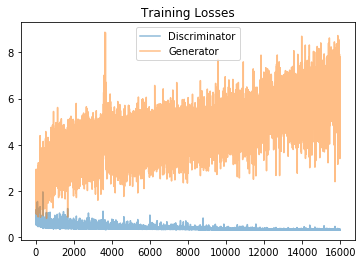

In [119]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [120]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [121]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

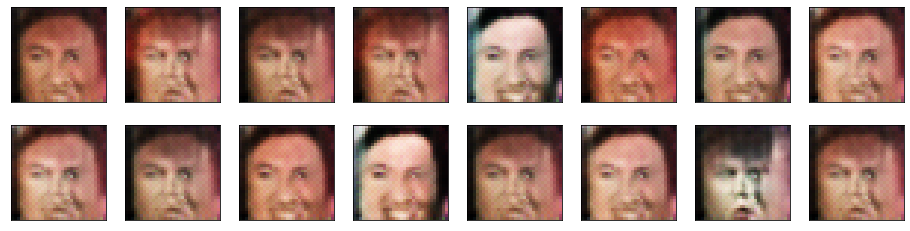

In [122]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
* The ethnic look for the fake faces reflects the training data which is biased toward caucasians.
* Having deeper model would likely pickup more details but is harder to train.
* The number of epochs does affect the clarity of the generated faces. More epochs create clearer pictures. 
* The "adversarial" part of the model can be seen in the generator and discriminator losses. The appears to take turn one "round" the generator see reduction in loss which is often paired with an increase in loss on the discriminator. Then the tred changes and loss decrease on discriminator and increases on generator.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.